# CRE/MF Mortgage Rate Model

# Setup

In [1]:
# Data libraries 
import pandas as pd
import missingno as msno
from tabulate import tabulate

# ML libraries
import statistics
import random
import numpy as np
from numpy import argmax
import scipy.stats as stats
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import pacf, acf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import lilliefors
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.sandbox.stats.runs import runstest_1samp
from arch.unitroot import PhillipsPerron
from arch.unitroot import ZivotAndrews
from arch.unitroot import DFGLS
from statsmodels.tsa.seasonal import seasonal_decompose
import xgboost as xgb

# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.graphics.gofplots import qqplot
%matplotlib inline

### Load Data 

In [2]:
df = pd.read_csv("/Users/juanvalidmind/Dev/github/validmind/validmind-python/notebooks/datasets/lending_club_loan_rates.csv", sep='\t')
df = df.rename(columns={'Unnamed: 0': 'Date'})
df = df.set_index(pd.to_datetime(df['Date']))
df.drop(["Date"], axis=1, inplace=True)
df.head()

loan_rate_A  loan_rate_B  loan_rate_C  loan_rate_D  FEDFUNDS  \
Date                                                                       
2007-08-01     7.766667     9.497692    10.947500    12.267000      5.02   
2007-09-01     7.841429     9.276667    10.829167    12.436667      4.94   
2007-10-01     7.830000     9.433333    10.825926    12.737368      4.76   
2007-11-01     7.779091     9.467778    10.967037    12.609444      4.49   
2007-12-01     7.695833     9.387500    10.805000    12.478889      4.24   

            diff1_loan_rate_A  diff1_loan_rate_B  diff1_loan_rate_C  \
Date                                                                  
2007-08-01           0.060000           0.134359           0.207500   
2007-09-01           0.074762          -0.221026          -0.118333   
2007-10-01          -0.011429           0.156667          -0.003241   
2007-11-01          -0.050909           0.034444           0.141111   
2007-12-01          -0.083258          -0.080278          -0.162037   

            diff1_loan_rate_D  diff1_FEDFUNDS  diff2_FEDFUNDS  
Date                                                           
2007-08-01          -0.467444           -0.24           -0.25  
2007-09-01           0.169667           -0.08            0.16  
2007-10-01           0.300702           -0.18           -0.10  
2007-11-01          -0.127924           -0.27           -0.09  
2007-12-01          -0.130556           -0.25            0.02

### Visual Inspection

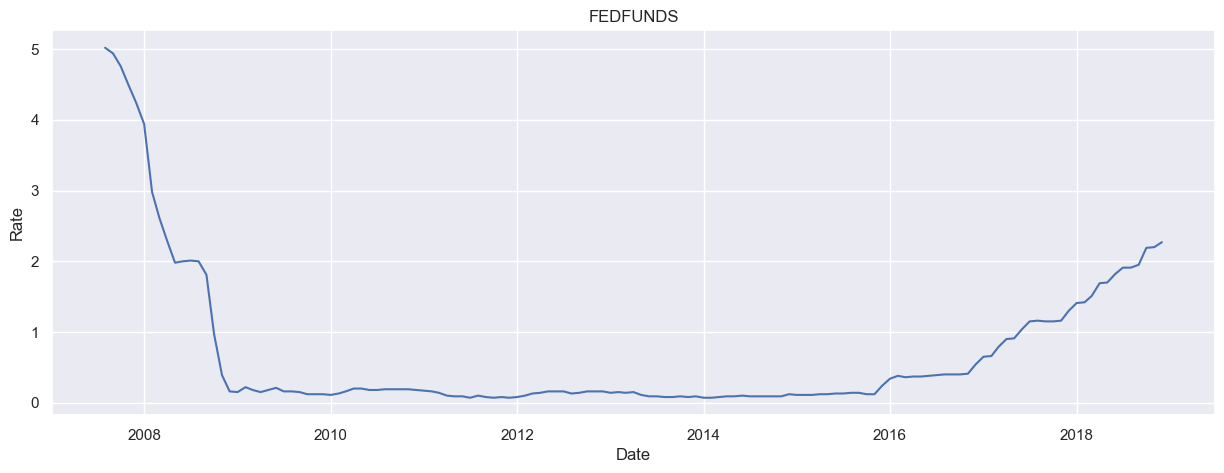

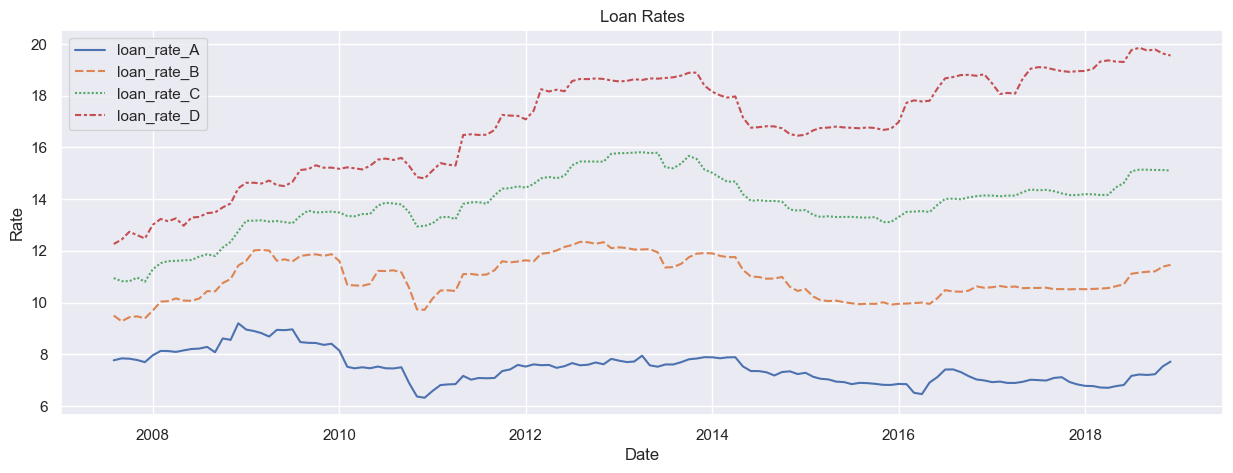

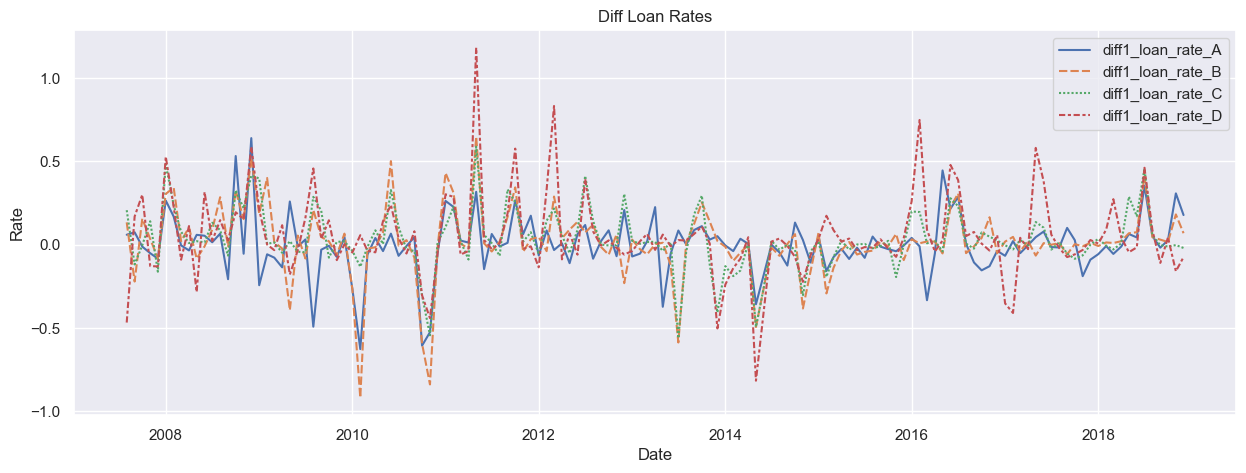

In [3]:
# FEDFUNDS plot
sns.set(rc={"figure.figsize": (15, 5)})
sns.lineplot(data=df["FEDFUNDS"])
plt.title("FEDFUNDS")
plt.xlabel("Date")
plt.ylabel("Rate")
plt.show()

# Loan rates plot
loan_rates = df[["loan_rate_A", "loan_rate_B", "loan_rate_C", "loan_rate_D"]]
sns.set(rc={"figure.figsize": (15, 5)})
sns.lineplot(data=loan_rates)
plt.title("Loan Rates")
plt.xlabel("Date")
plt.ylabel("Rate")
plt.show()

# Diff loan rates plot
diff_loan_rates = df[["diff1_loan_rate_A", "diff1_loan_rate_B", "diff1_loan_rate_C", "diff1_loan_rate_D"]]
sns.set(rc={"figure.figsize": (15, 5)})
sns.lineplot(data=diff_loan_rates)
plt.title("Diff Loan Rates")
plt.xlabel("Date")
plt.ylabel("Rate")
plt.show()

# 4. Model Development

# 4.1. Development Data and Platform

## 4.1.2. Data Quality and Relevance

## 4.1.3. Data Process, Adjustments and Treatment

 ## A. Missing Values Analysis

**Step 1: Calculate the percentage of missing values in each column**

In [4]:
missing_values = df.isnull().sum() / len(df) * 100
missing_values_df = pd.DataFrame({"column_name": missing_values.index, "missing_percentage": missing_values.values})
missing_values_df = missing_values_df.sort_values("missing_percentage", ascending=False)

**Step 2: Display the missing values percentage in a table format**

In [5]:
display(missing_values_df)

column_name  missing_percentage
0         loan_rate_A                 0.0
1         loan_rate_B                 0.0
2         loan_rate_C                 0.0
3         loan_rate_D                 0.0
4            FEDFUNDS                 0.0
5   diff1_loan_rate_A                 0.0
6   diff1_loan_rate_B                 0.0
7   diff1_loan_rate_C                 0.0
8   diff1_loan_rate_D                 0.0
9      diff1_FEDFUNDS                 0.0
10     diff2_FEDFUNDS                 0.0

**Step 3: Visualize the missing values**

Create a bar plot to show the missing values percentage per column.

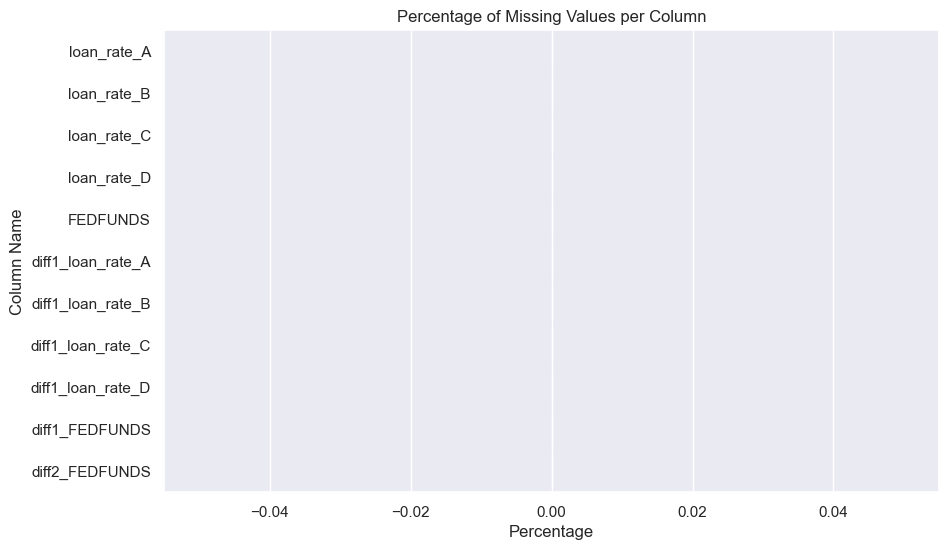

In [6]:
plt.figure(figsize=(10, 6))
sns.barplot(x="missing_percentage", y="column_name", data=missing_values_df, orient="h")
plt.title("Percentage of Missing Values per Column")
plt.xlabel("Percentage")
plt.ylabel("Column Name")
plt.show()

Create a matrix plot to show the pattern of missing values in the dataset.

<Figure size 1000x600 with 0 Axes>

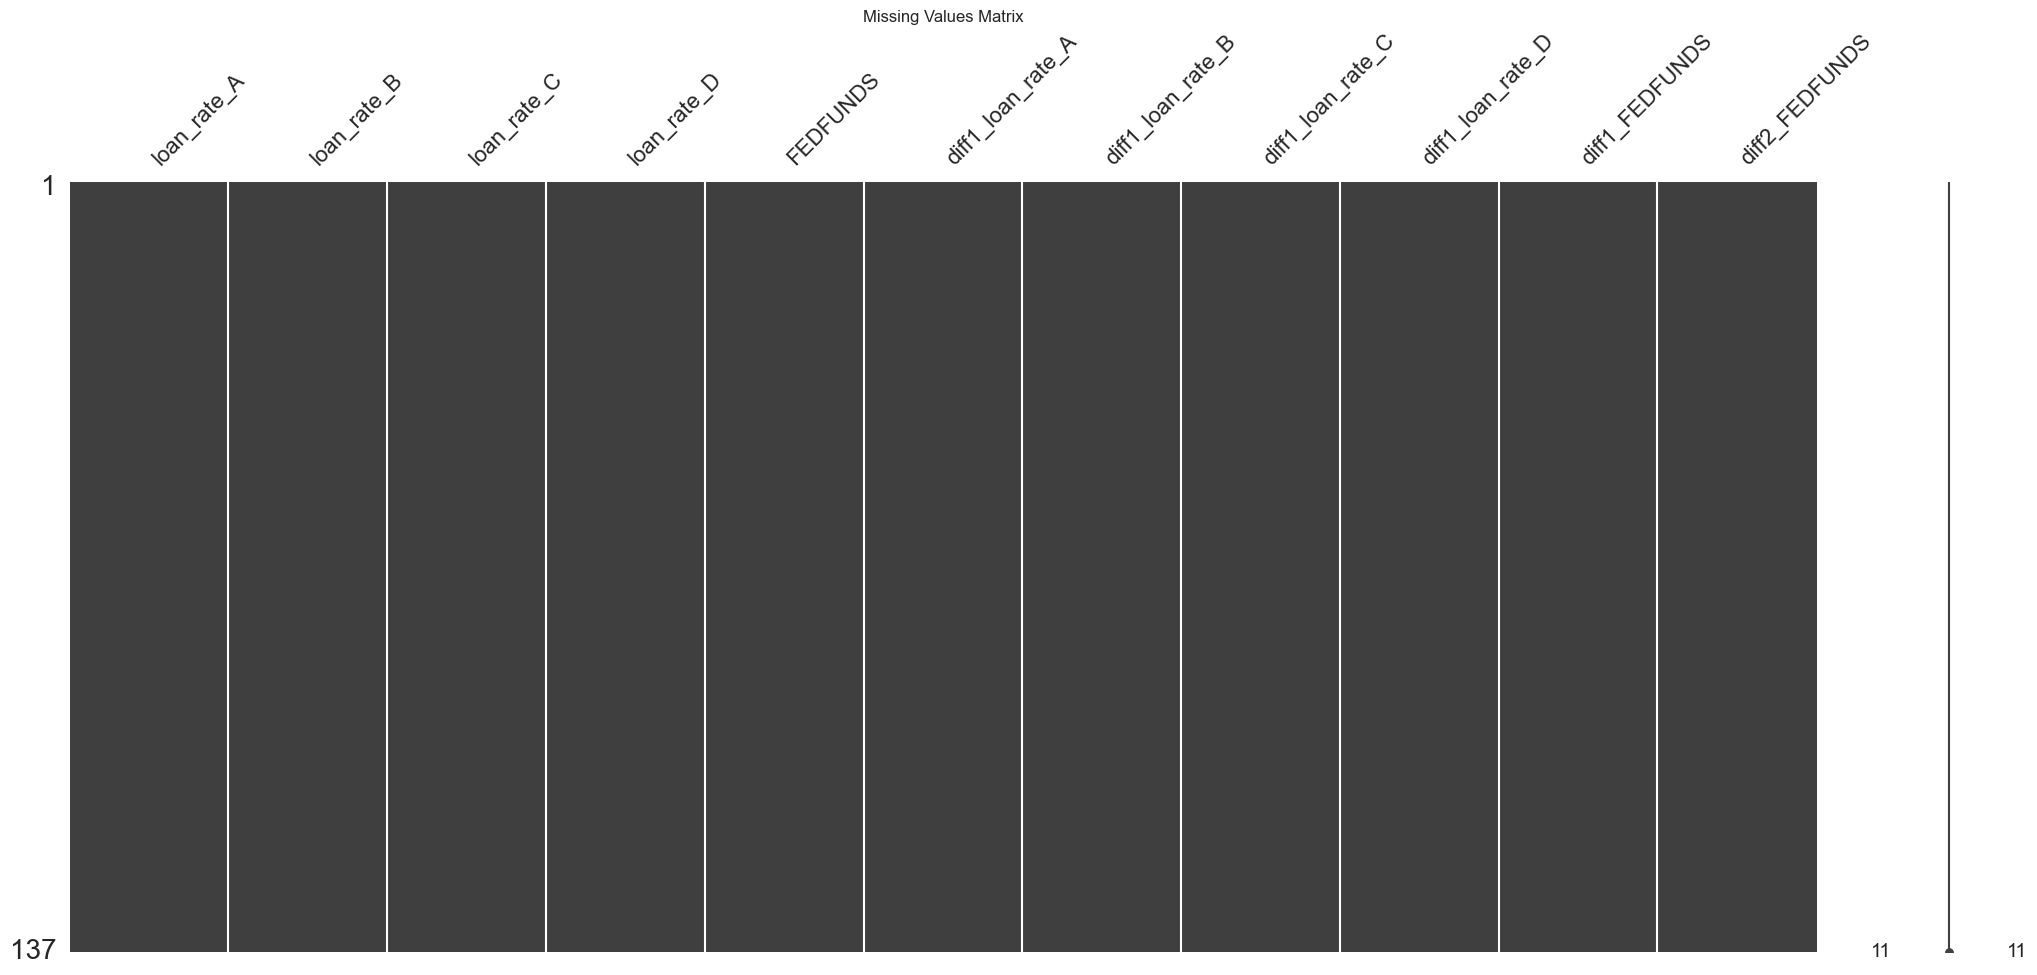

In [7]:
plt.figure(figsize=(10, 6))
msno.matrix(df)
plt.title("Missing Values Matrix")
plt.show()

**Step 4: Analyze the patterns of missing values**

Based on the bar plot and matrix plot, analyze if the missing values are random or if there are specific patterns in the data.

**Step 5: Handle missing values**

Based on the analysis, decide how to handle the missing values. 

 ## B. Outliers Analysis

**Step 1: Visualize the dataset using box plots**

Visualize the data using box plots to get an initial sense of the presence of outliers.

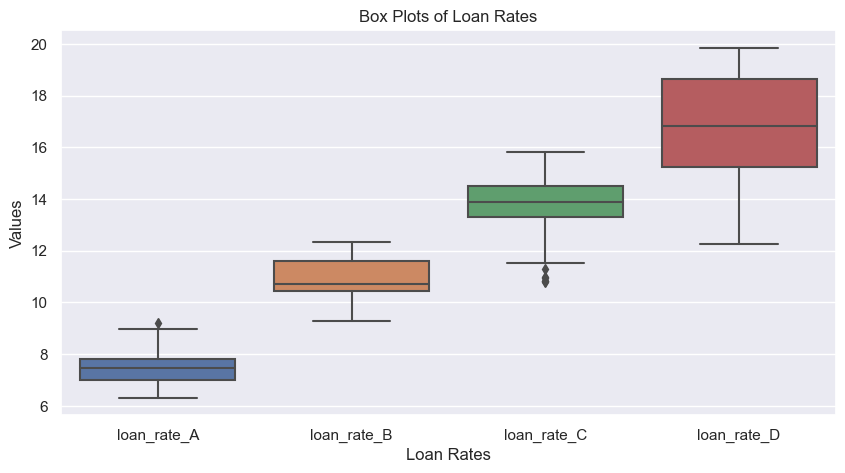

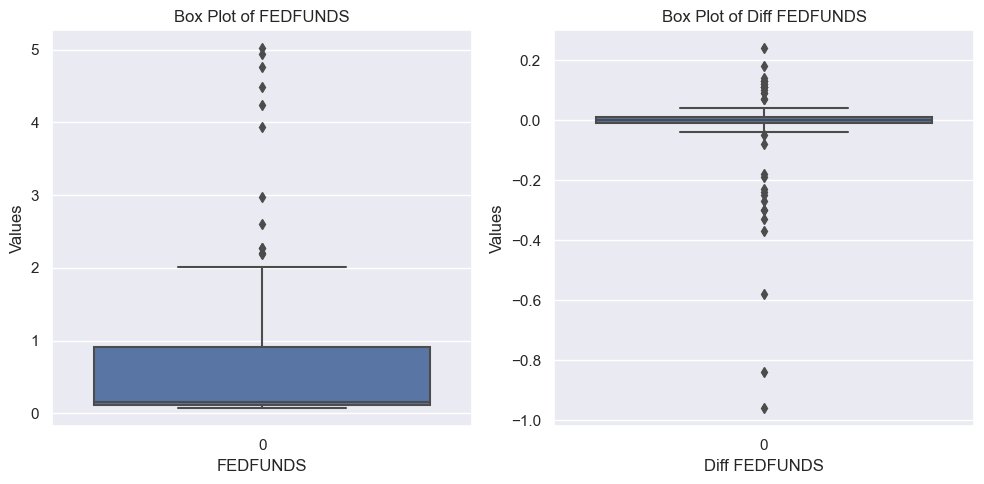

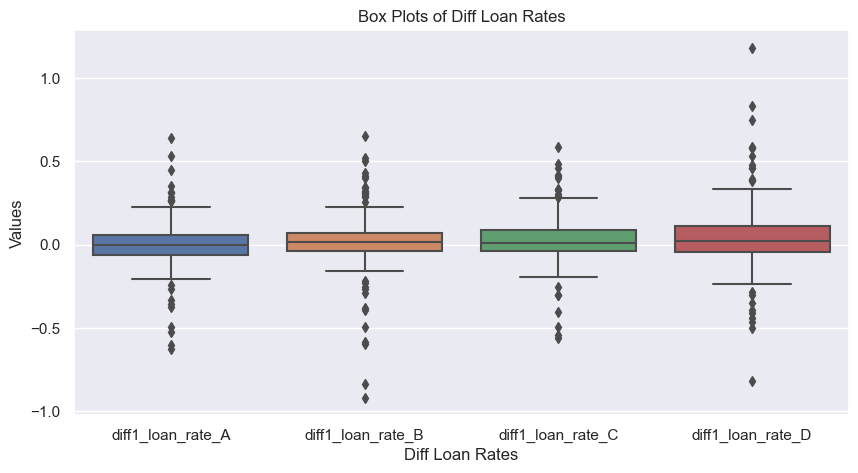

In [8]:
# Box plot for loan rates
loan_rates = df[["loan_rate_A", "loan_rate_B", "loan_rate_C", "loan_rate_D"]]
sns.set(rc={"figure.figsize": (10, 5)})
sns.boxplot(data=loan_rates)
plt.title("Box Plots of Loan Rates")
plt.xlabel("Loan Rates")
plt.ylabel("Values")
plt.show()

# Box plot for FEDFUNDS and diff FEDFUNDS
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.boxplot(data=df["FEDFUNDS"], ax=axes[0])
axes[0].set_title("Box Plot of FEDFUNDS")
axes[0].set_xlabel("FEDFUNDS")
axes[0].set_ylabel("Values")

sns.boxplot(data=df["diff1_FEDFUNDS"], ax=axes[1])
axes[1].set_title("Box Plot of Diff FEDFUNDS")
axes[1].set_xlabel("Diff FEDFUNDS")
axes[1].set_ylabel("Values")

plt.tight_layout()
plt.show()

# Box plot for diff loan rates
diff_loan_rates = df[["diff1_loan_rate_A", "diff1_loan_rate_B", "diff1_loan_rate_C", "diff1_loan_rate_D"]]
sns.set(rc={"figure.figsize": (10, 5)})
sns.boxplot(data=diff_loan_rates)
plt.title("Box Plots of Diff Loan Rates")
plt.xlabel("Diff Loan Rates")
plt.ylabel("Values")
plt.show()


**Step 2: Calculate Z-scores**

Calculate the Z-scores for each column in your dataset to identify data points that are far from the mean.

In [9]:
z_scores = np.abs(stats.zscore(df))

**Step 3: Set a threshold and identify outliers**

Set a threshold (e.g., 3) to identify data points with Z-scores higher than the threshold.

In [10]:
threshold = 3
outliers = np.where(z_scores > threshold)
outliers_df = pd.DataFrame({"row": outliers[0], "column": outliers[1]})

**Step 4: Analyze the outliers**

Analyze the outliers by looking at their frequency, index, and corresponding column.

In [11]:
outliers_count = outliers_df.groupby(["row", "column"]).size().reset_index(name="count")
outliers_info = outliers_count.merge(outliers_df, on=["row", "column"], how="left")

# Add the column names and dates to the outliers_info DataFrame
outliers_info["column_name"] = outliers_info["column"].apply(lambda x: df.columns[x])
outliers_info["date"] = outliers_info["row"].apply(lambda x: df.index[x])

# Reorder, sort by column_name, and display the DataFrame
outliers_info = outliers_info[["date", "column_name", "count"]].sort_values(by="column_name")
display(outliers_info)


date        column_name  count
0  2007-08-01           FEDFUNDS      1
1  2007-09-01           FEDFUNDS      1
2  2007-10-01           FEDFUNDS      1
3  2007-11-01           FEDFUNDS      1
4  2007-12-01           FEDFUNDS      1
5  2008-01-01           FEDFUNDS      1
10 2008-10-01     diff1_FEDFUNDS      1
12 2008-11-01     diff1_FEDFUNDS      1
6  2008-02-01     diff1_FEDFUNDS      1
16 2010-10-01  diff1_loan_rate_A      1
9  2008-10-01  diff1_loan_rate_A      1
13 2008-12-01  diff1_loan_rate_A      1
14 2010-02-01  diff1_loan_rate_A      1
17 2010-11-01  diff1_loan_rate_A      1
15 2010-02-01  diff1_loan_rate_B      1
18 2010-11-01  diff1_loan_rate_B      1
20 2011-05-01  diff1_loan_rate_B      1
24 2013-07-01  diff1_loan_rate_C      1
19 2010-11-01  diff1_loan_rate_C      1
21 2011-05-01  diff1_loan_rate_C      1
23 2012-03-01  diff1_loan_rate_D      1
22 2011-05-01  diff1_loan_rate_D      1
25 2014-05-01  diff1_loan_rate_D      1
11 2008-10-01     diff2_FEDFUNDS      1
7  2008-02-01     diff2_FEDFUNDS      1
8  2008-03-01     diff2_FEDFUNDS      1

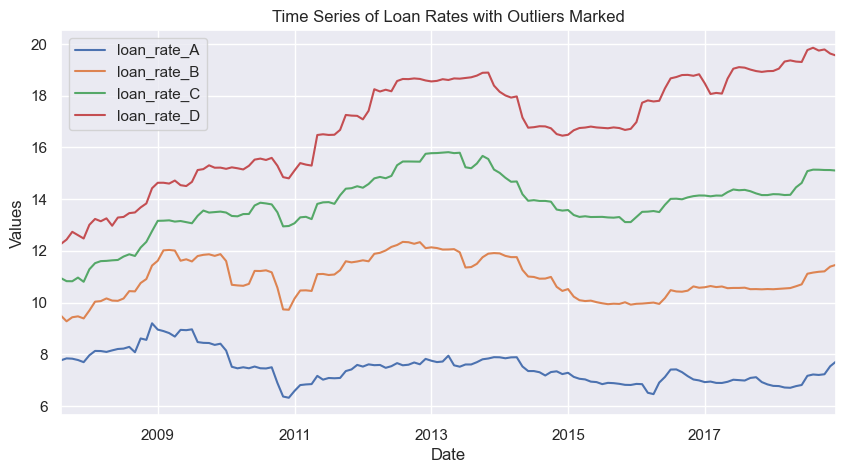

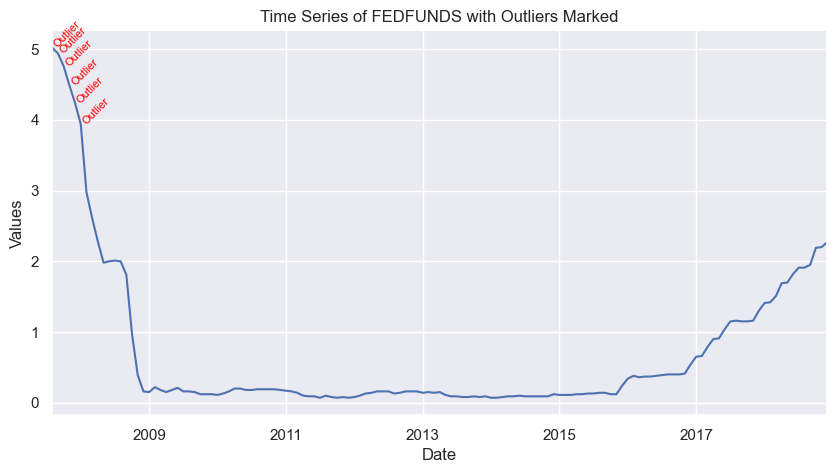

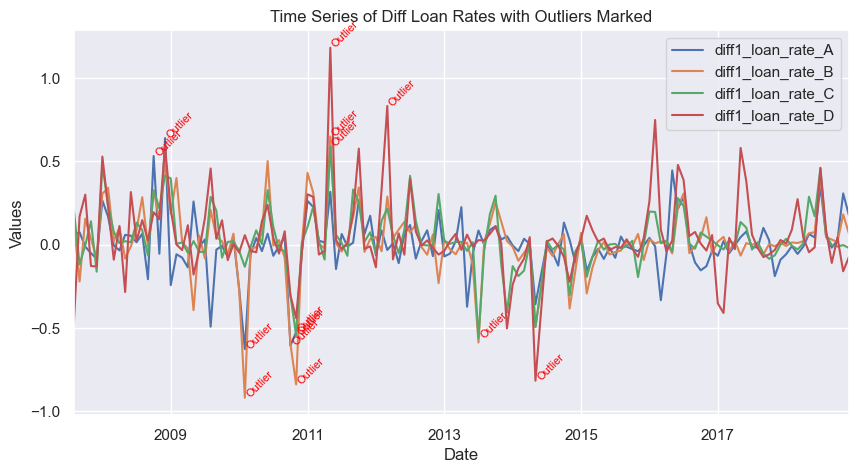

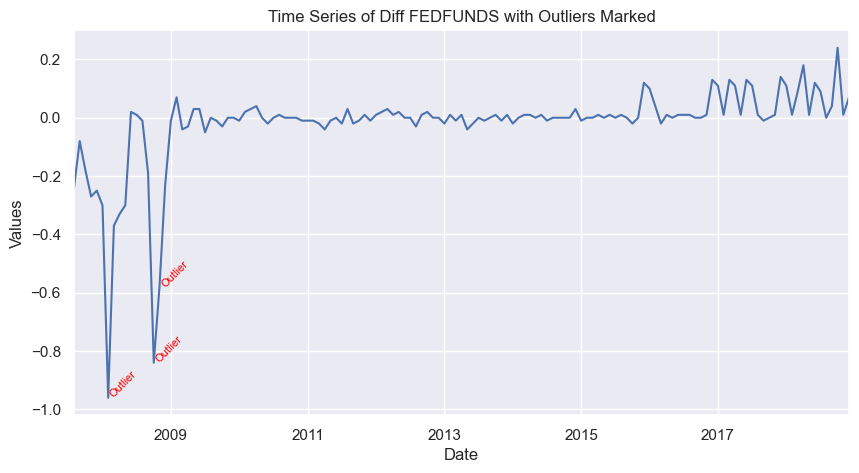

In [12]:
# Time series plot for loan rates with outliers marked
loan_rates = df[["loan_rate_A", "loan_rate_B", "loan_rate_C", "loan_rate_D"]]
loan_rates_outliers = outliers_info[outliers_info["column_name"].str.contains("loan_rate")]

fig, ax = plt.subplots(figsize=(10, 5))
loan_rates.plot(ax=ax)
loan_rates_outliers.apply(lambda x: ax.annotate('Outlier', xy=(x.date, df.loc[x.date][x.column_name]), 
                                                fontsize=8, color='red', rotation=45), axis=1)
plt.title("Time Series of Loan Rates with Outliers Marked")
plt.xlabel("Date")
plt.ylabel("Values")
plt.show()

# Time series plot for FEDFUNDS with outliers marked
fed_funds_outliers = outliers_info[outliers_info["column_name"] == "FEDFUNDS"]

fig, ax = plt.subplots(figsize=(10, 5))
df["FEDFUNDS"].plot(ax=ax)
fed_funds_outliers.apply(lambda x: ax.annotate('Outlier', xy=(x.date, df.loc[x.date]["FEDFUNDS"]), 
                                               fontsize=8, color='red', rotation=45), axis=1)
plt.title("Time Series of FEDFUNDS with Outliers Marked")
plt.xlabel("Date")
plt.ylabel("Values")
plt.show()

# Time series plot for diff loan rates with outliers marked
diff_loan_rates = df[["diff1_loan_rate_A", "diff1_loan_rate_B", "diff1_loan_rate_C", "diff1_loan_rate_D"]]
diff_loan_rates_outliers = outliers_info[outliers_info["column_name"].str.contains("diff1_loan_rate")]

fig, ax = plt.subplots(figsize=(10, 5))
diff_loan_rates.plot(ax=ax)
diff_loan_rates_outliers.apply(lambda x: ax.annotate('Outlier', xy=(x.date, df.loc[x.date][x.column_name]), 
                                                     fontsize=8, color='red', rotation=45), axis=1)
plt.title("Time Series of Diff Loan Rates with Outliers Marked")
plt.xlabel("Date")
plt.ylabel("Values")
plt.show()

# Time series plot for diff FEDFUNDS with outliers marked
diff_fed_funds_outliers = outliers_info[outliers_info["column_name"] == "diff1_FEDFUNDS"]

fig, ax = plt.subplots(figsize=(10, 5))
df["diff1_FEDFUNDS"].plot(ax=ax)
diff_fed_funds_outliers.apply(lambda x: ax.annotate('Outlier', xy=(x.date, df.loc[x.date]["diff1_FEDFUNDS"]), 
                                                    fontsize=8, color='red', rotation=45), axis=1)
plt.title("Time Series of Diff FEDFUNDS with Outliers Marked")
plt.xlabel("Date")
plt.ylabel("Values")
plt.show()


## C. Seasonality Analysis

**Step 1: Seasonal decomposition**

Perform seasonal decomposition on each time series.

In [13]:
freq = 12  # Assuming monthly data, adjust the frequency accordingly

loan_rate_decompositions = {}
for col in loan_rates.columns:
    loan_rate_decompositions[col] = seasonal_decompose(df[col], model='additive', period=freq)

fed_funds_decomposition = seasonal_decompose(df["FEDFUNDS"], model='additive', period=freq)

diff_loan_rate_decompositions = {}
for col in diff_loan_rates.columns:
    diff_loan_rate_decompositions[col] = seasonal_decompose(df[col], model='additive', period=freq)


**Step 2: Visualize seasonal decomposition**

Create plots for seasonal components.

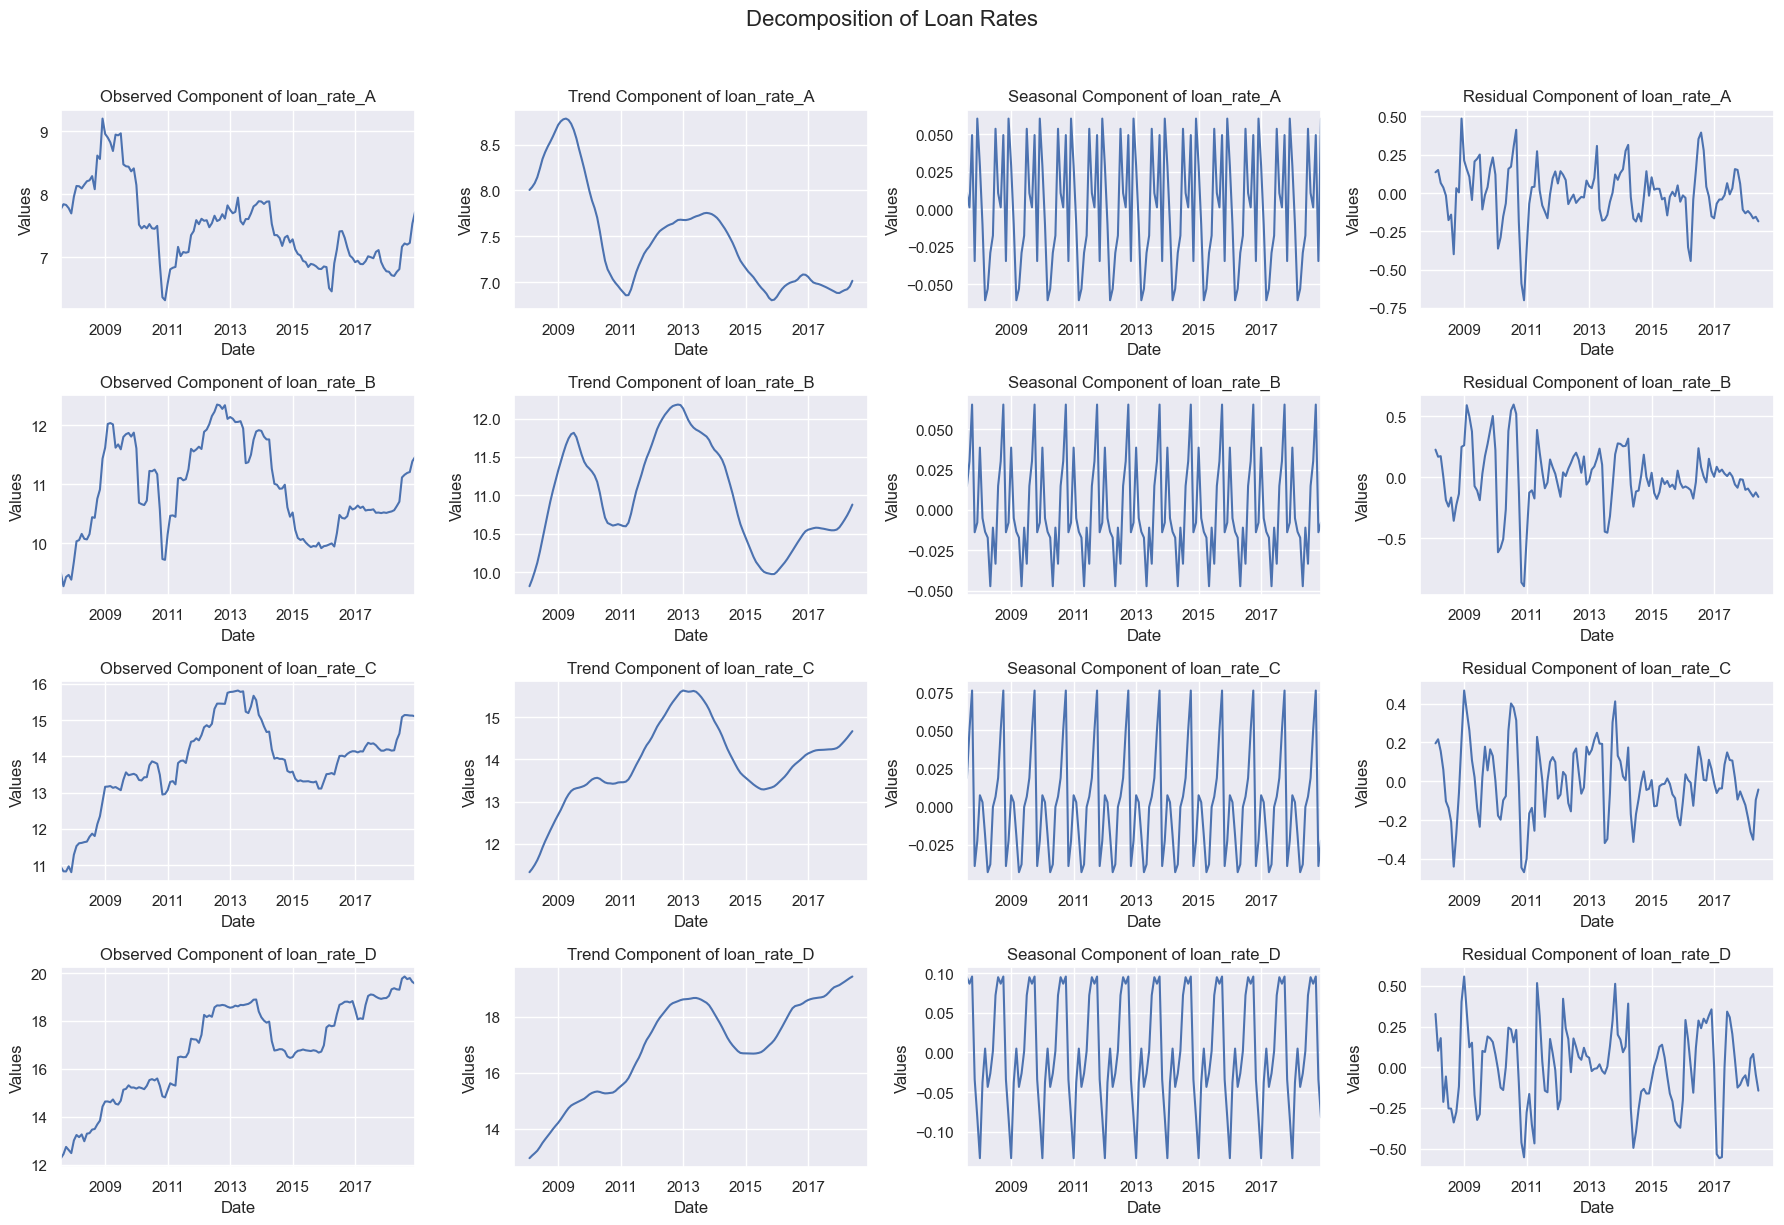

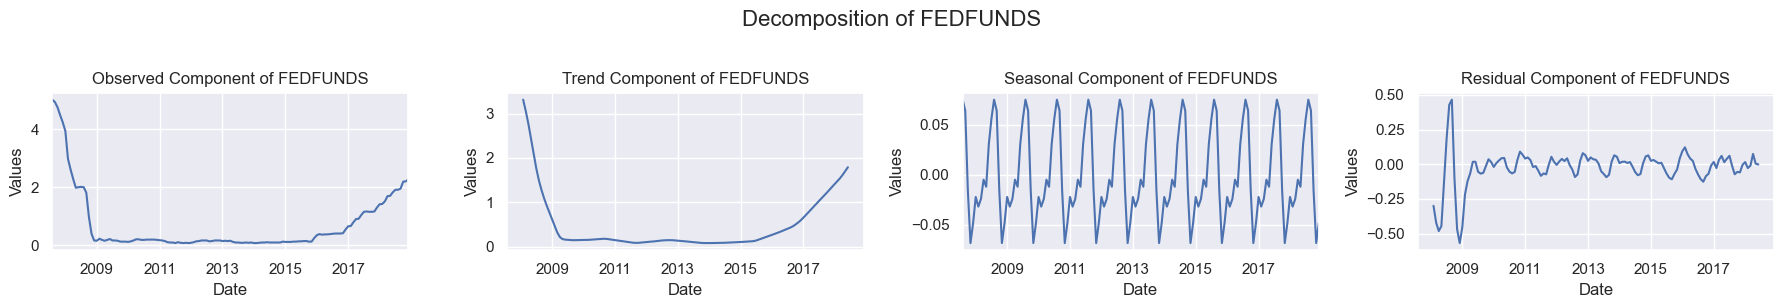

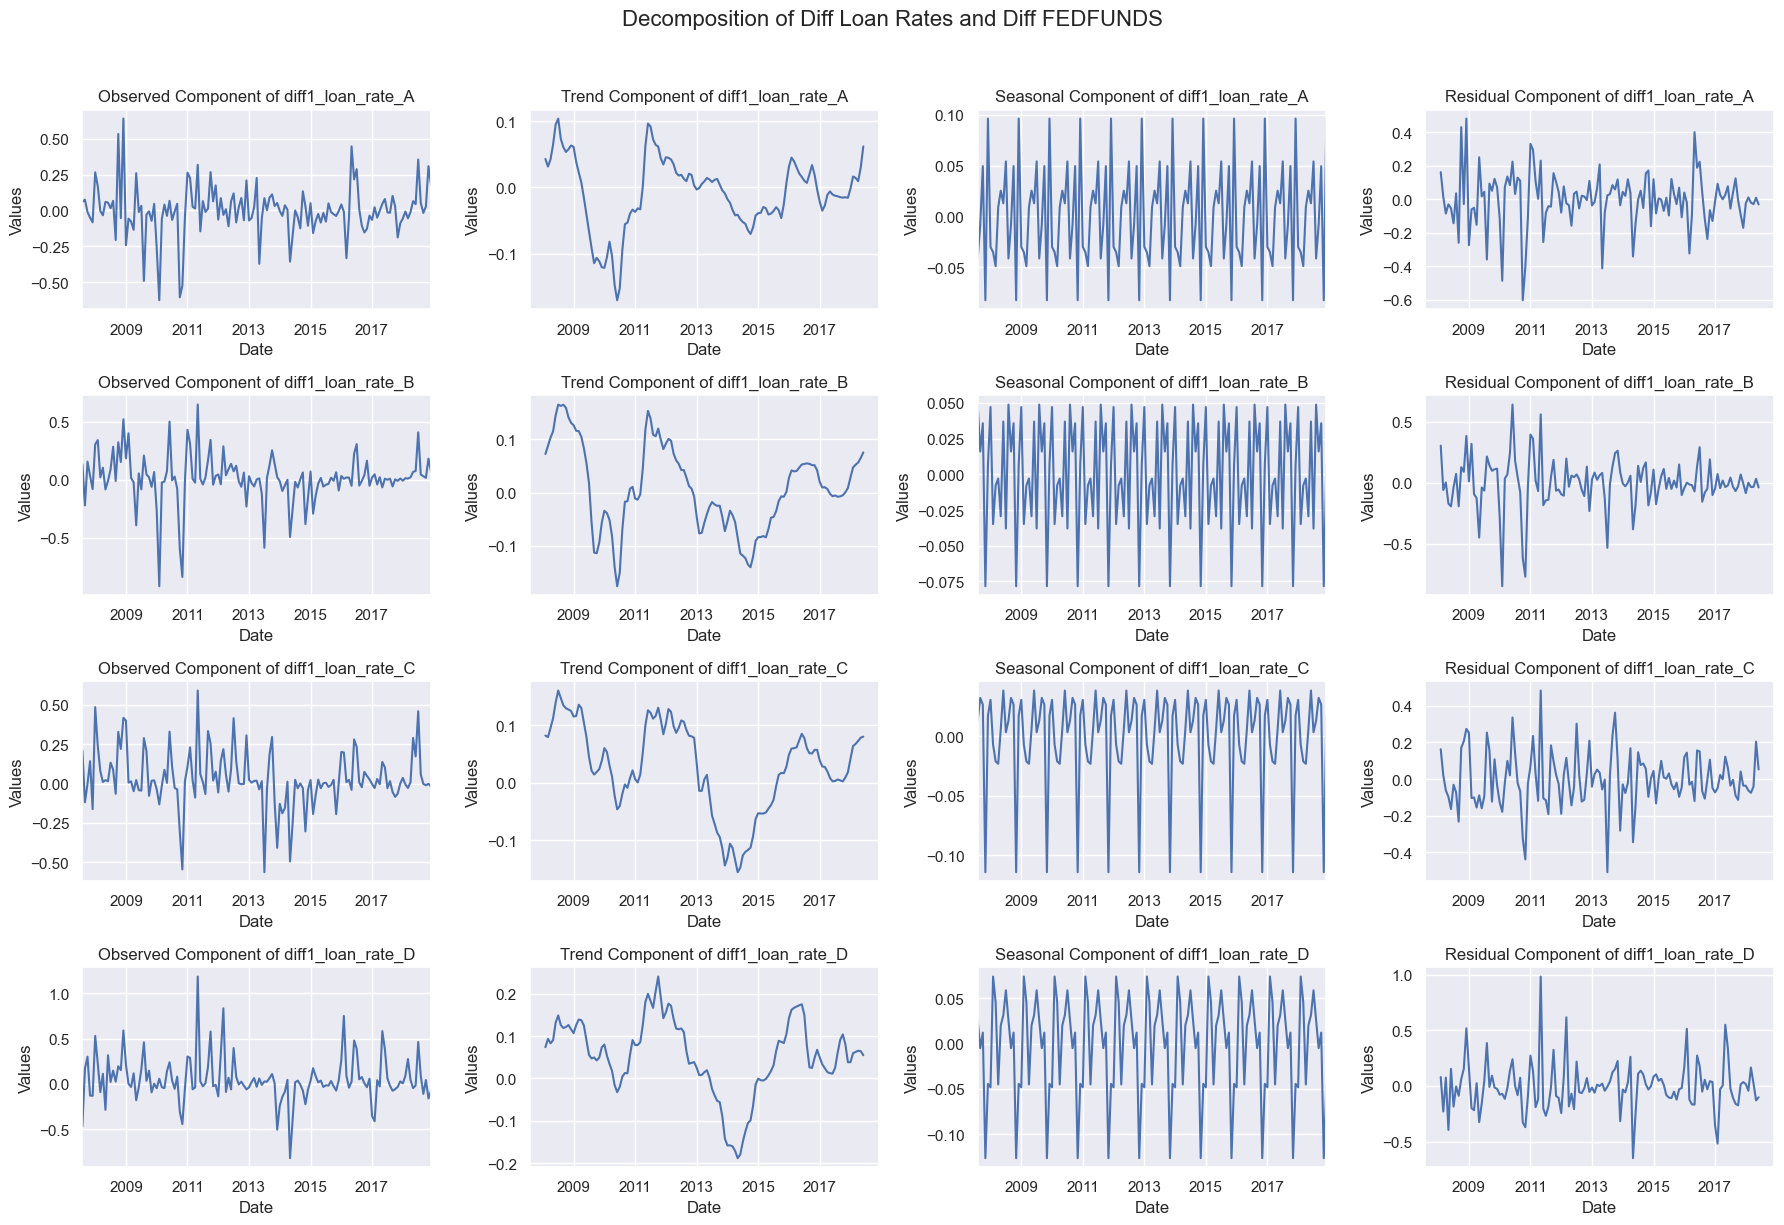

In [14]:
def plot_decomposition_components(series_decompositions, title):
    n = len(series_decompositions)
    fig, axes = plt.subplots(nrows=n, ncols=4, figsize=(18, 3 * n))
    
    if n == 1:
        axes = [axes]  # Make sure axes is a list even when there's only one subplot
    
    for row_axes, (col, decomposition) in zip(axes, series_decompositions.items()):
        for ax, component, comp_title in zip(row_axes, [decomposition.observed, decomposition.trend, decomposition.seasonal, decomposition.resid],
                                            ["Observed", "Trend", "Seasonal", "Residual"]):
            component.plot(ax=ax)
            ax.set_title(f"{comp_title} Component of {col}")
            ax.set_ylabel("Values")
    
    plt.suptitle(title, y=1.02, fontsize=16)
    plt.tight_layout()
    plt.show()

plot_decomposition_components(loan_rate_decompositions, "Decomposition of Loan Rates")
plot_decomposition_components({"FEDFUNDS": fed_funds_decomposition}, "Decomposition of FEDFUNDS")
plot_decomposition_components(diff_loan_rate_decompositions, "Decomposition of Diff Loan Rates and Diff FEDFUNDS")

Create ACF plots.

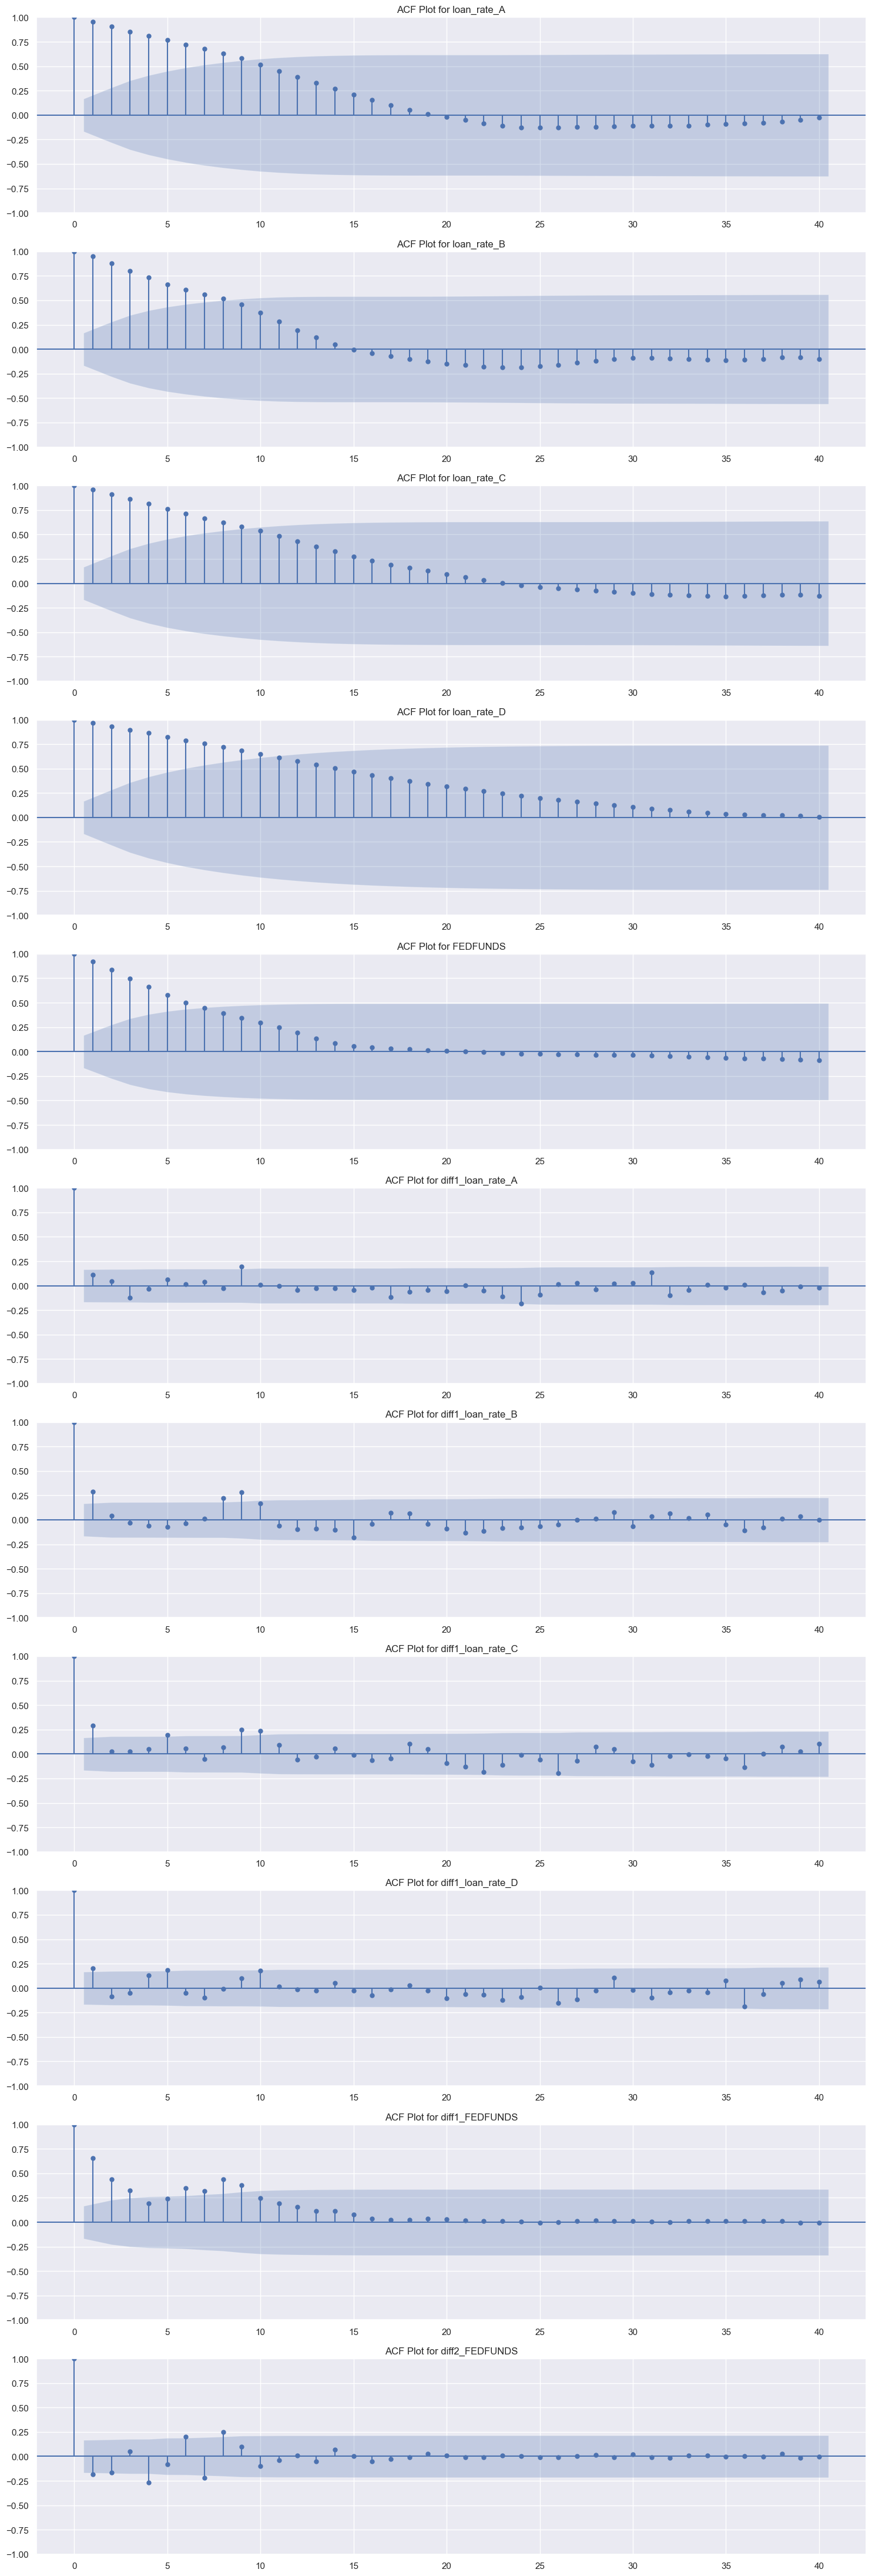

In [15]:

all_variables = [df['loan_rate_A'], df['loan_rate_B'], df['loan_rate_C'], df['loan_rate_D'], df['FEDFUNDS'], 
                 df['diff1_loan_rate_A'], df['diff1_loan_rate_B'], df['diff1_loan_rate_C'], df['diff1_loan_rate_D'], 
                 df['diff1_FEDFUNDS'], df['diff2_FEDFUNDS']]

# Create a figure with subplots
fig, ax = plt.subplots(11, 1, figsize=(15, 4*11))

# Plot ACF for each variable
for i, variable in enumerate(all_variables):
    plot_acf(variable, ax=ax[i], lags=40)
    ax[i].set_title("ACF Plot for {}".format(variable.name))

# Adjust the layout of the subplots
plt.tight_layout()


**Step 3: Residuals Analysis**

/Users/juanvalidmind/Library/Caches/pypoetry/virtualenvs/validmind-eEL8LtKG-py3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


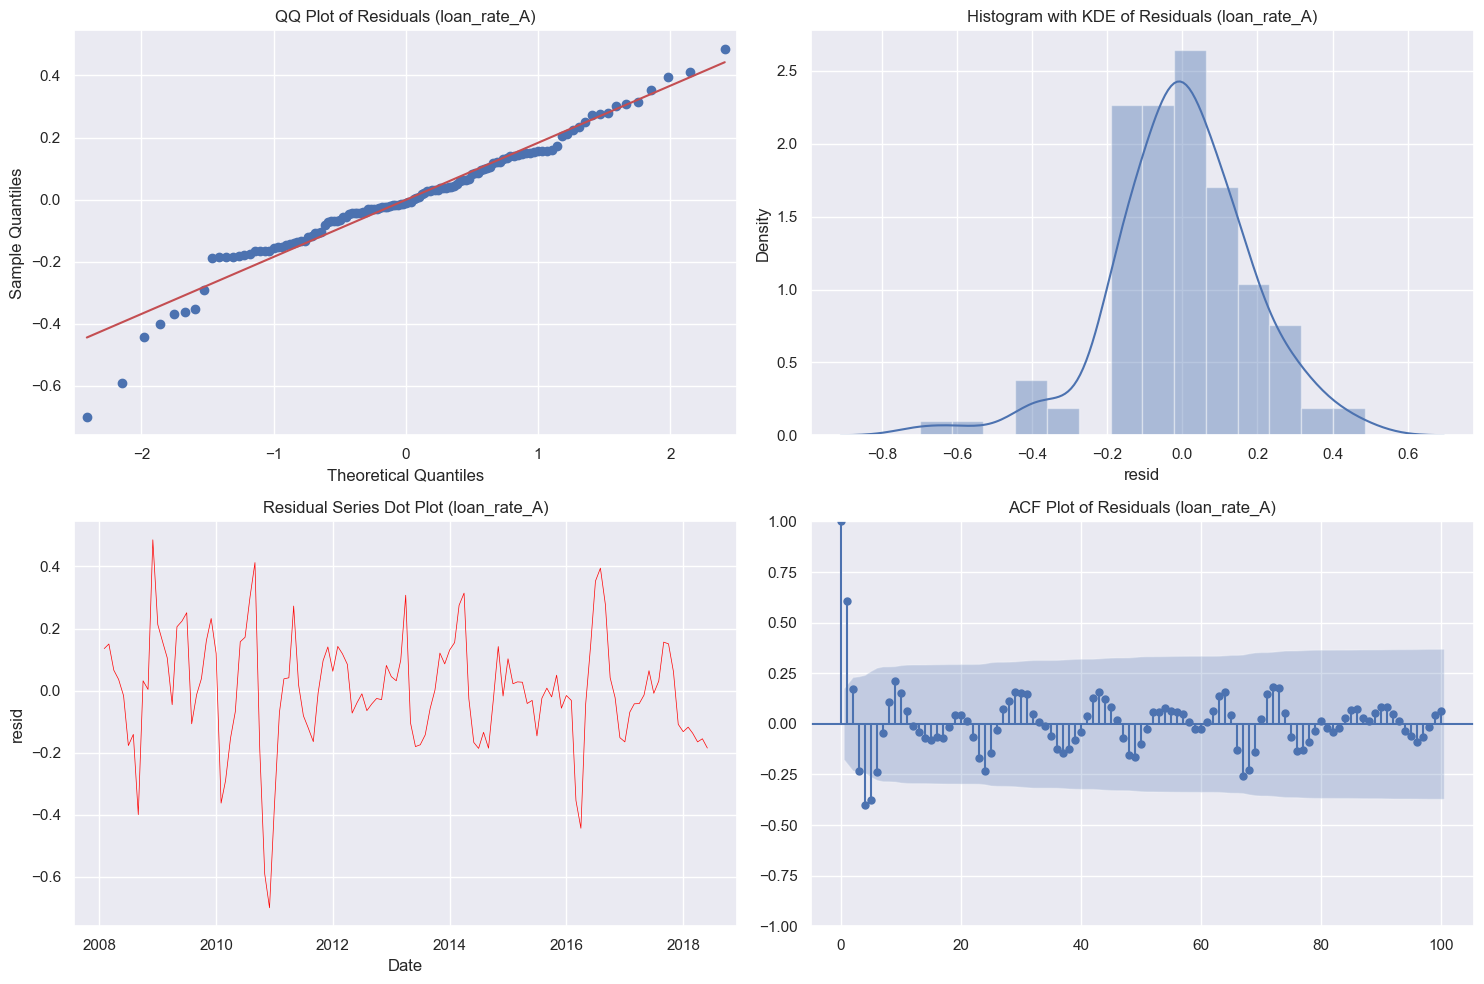

/Users/juanvalidmind/Library/Caches/pypoetry/virtualenvs/validmind-eEL8LtKG-py3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


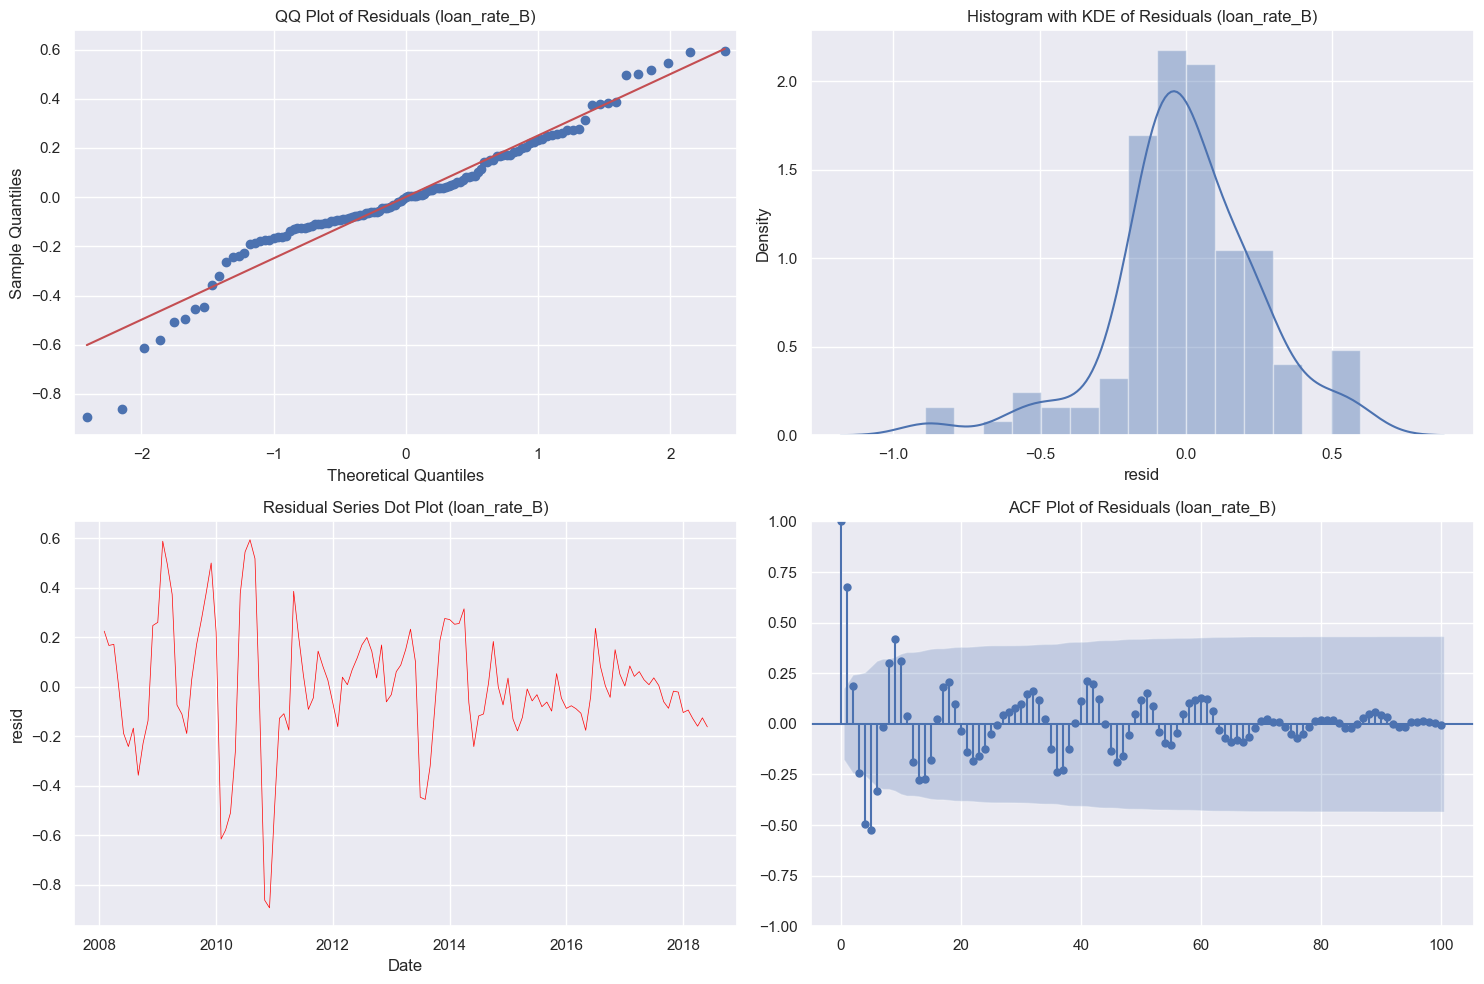

/Users/juanvalidmind/Library/Caches/pypoetry/virtualenvs/validmind-eEL8LtKG-py3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


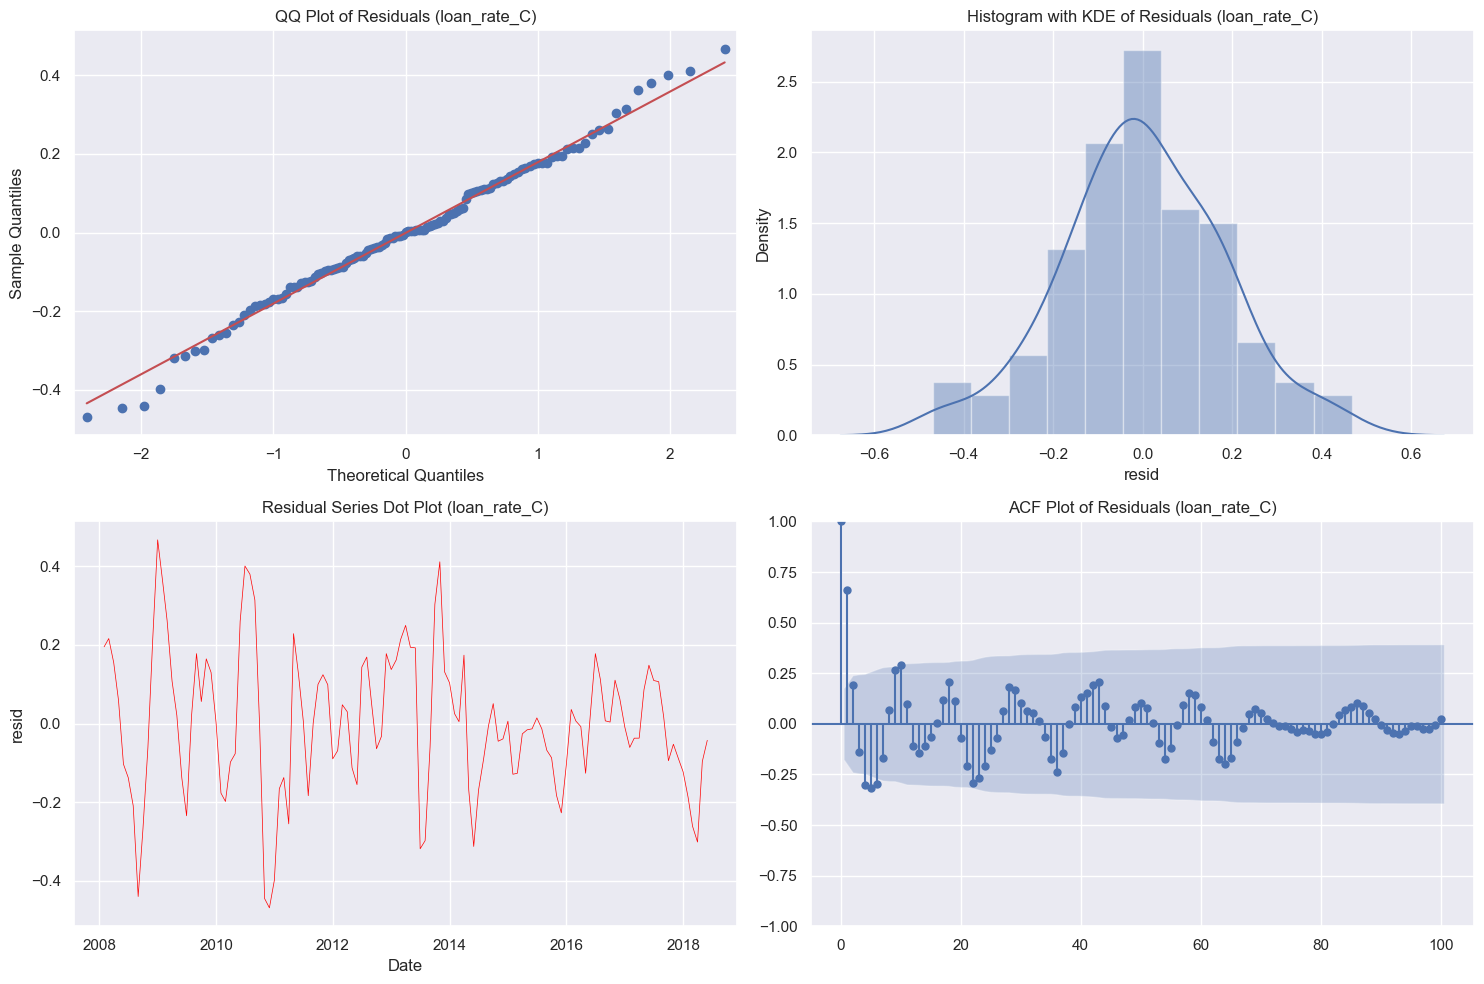

/Users/juanvalidmind/Library/Caches/pypoetry/virtualenvs/validmind-eEL8LtKG-py3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


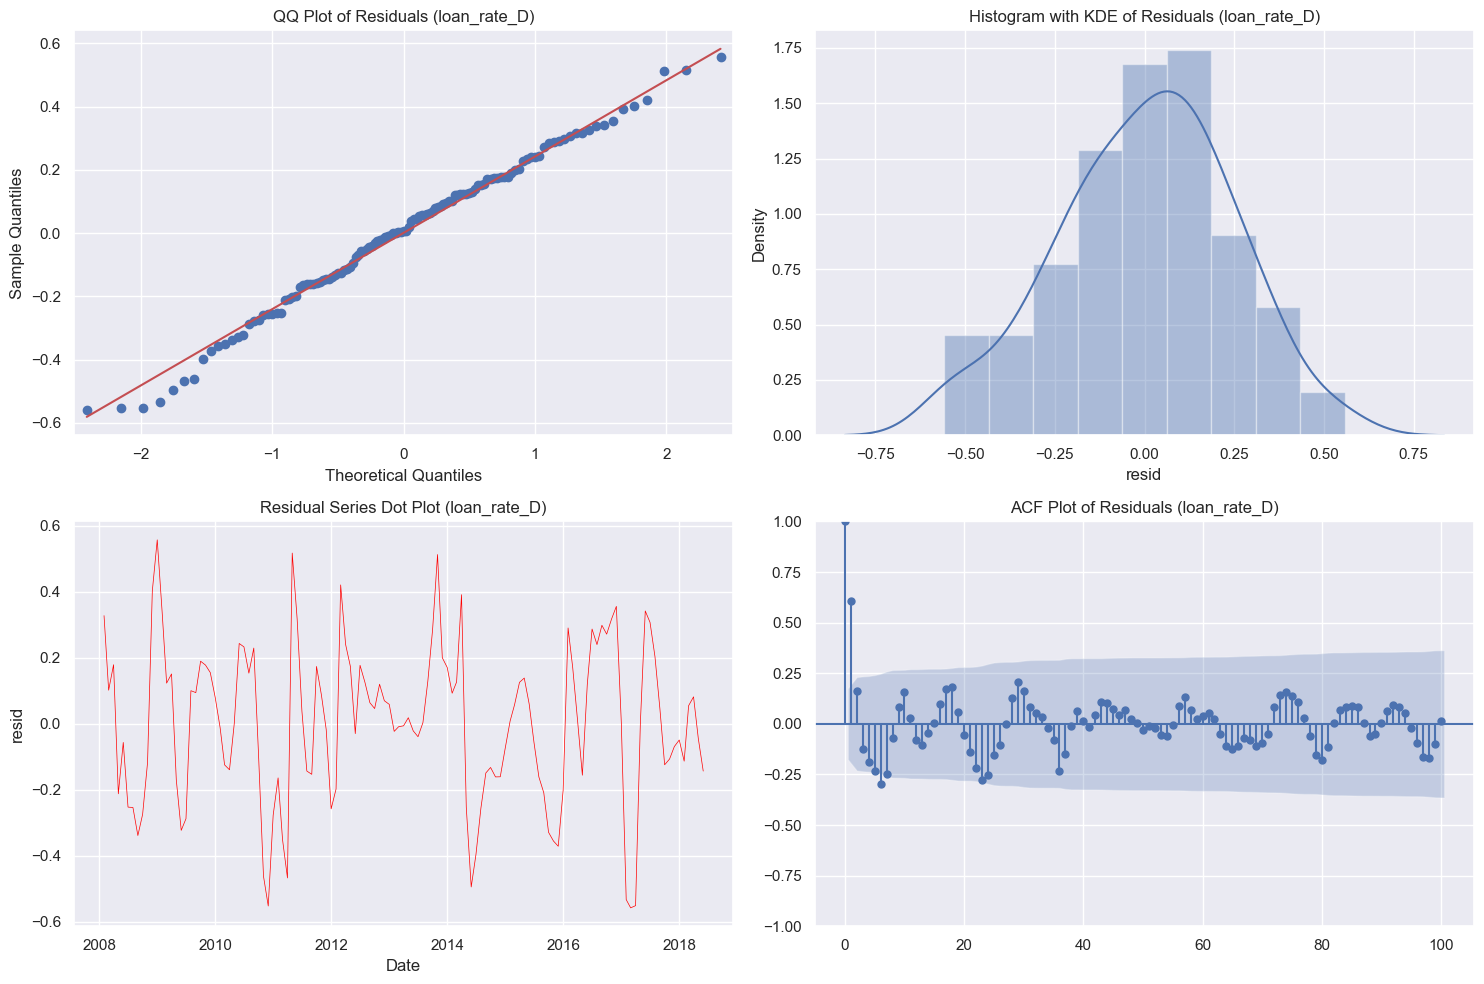

/Users/juanvalidmind/Library/Caches/pypoetry/virtualenvs/validmind-eEL8LtKG-py3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


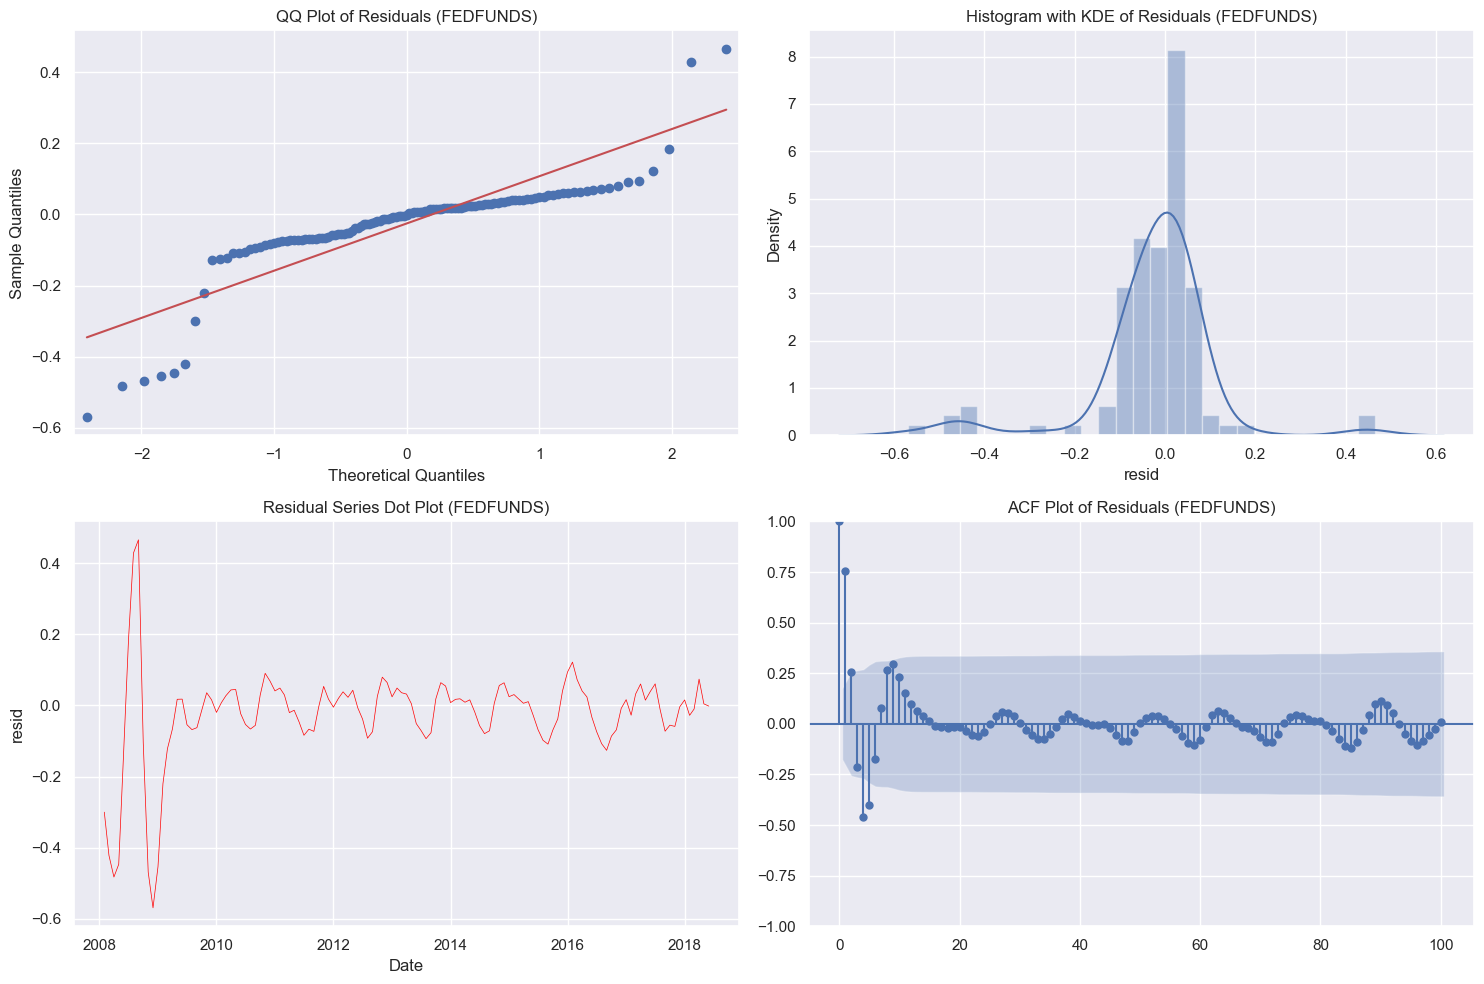

/Users/juanvalidmind/Library/Caches/pypoetry/virtualenvs/validmind-eEL8LtKG-py3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


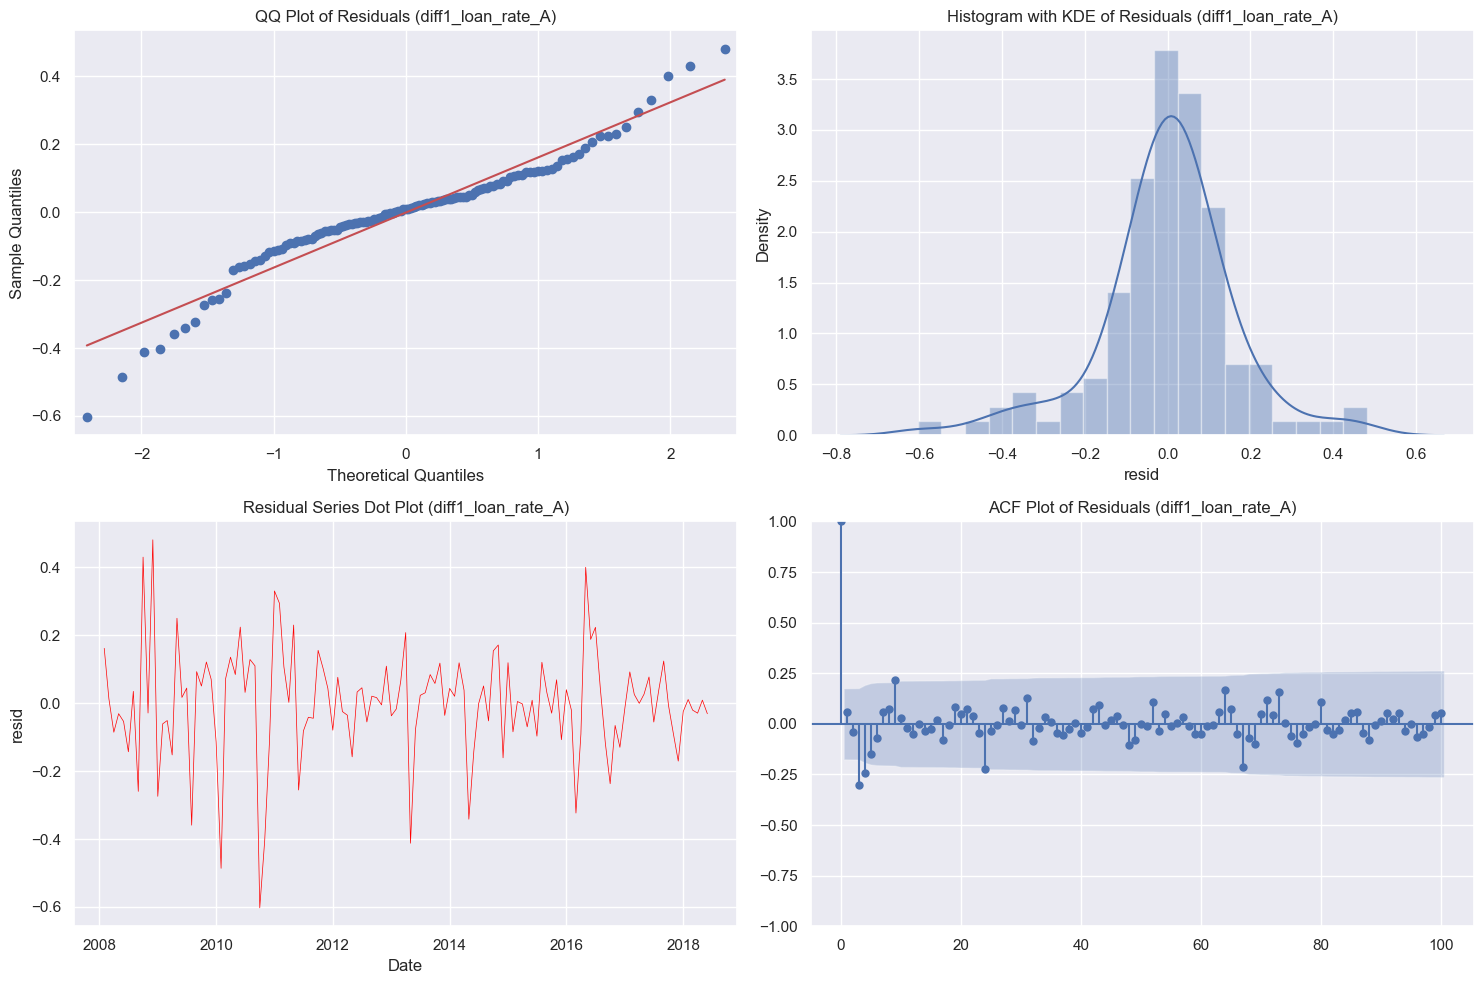

/Users/juanvalidmind/Library/Caches/pypoetry/virtualenvs/validmind-eEL8LtKG-py3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


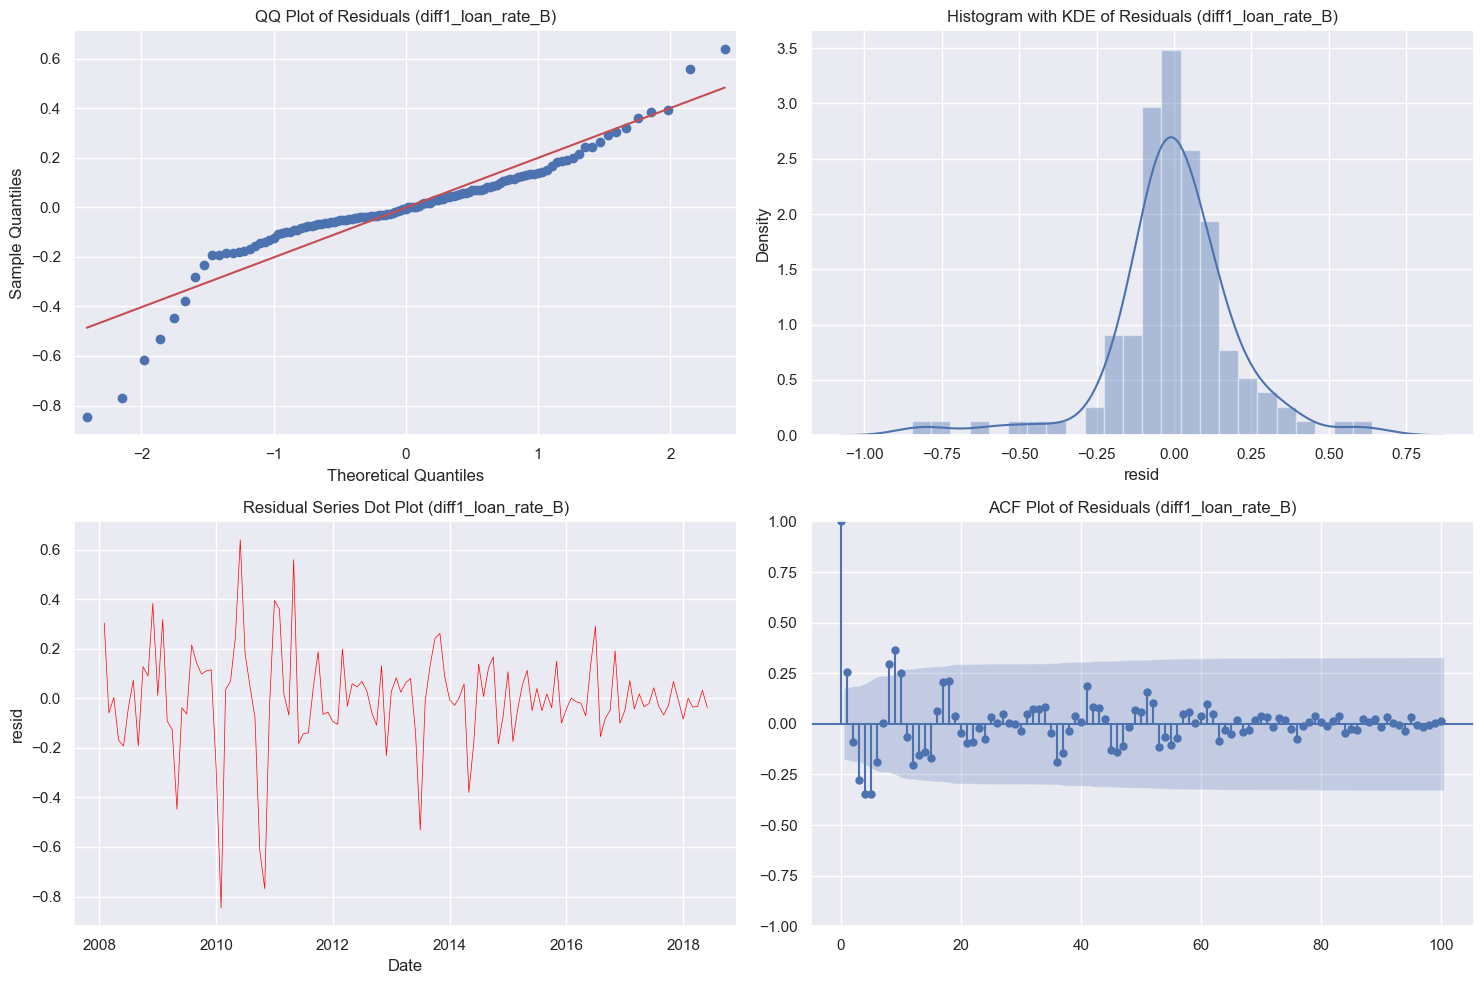

/Users/juanvalidmind/Library/Caches/pypoetry/virtualenvs/validmind-eEL8LtKG-py3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


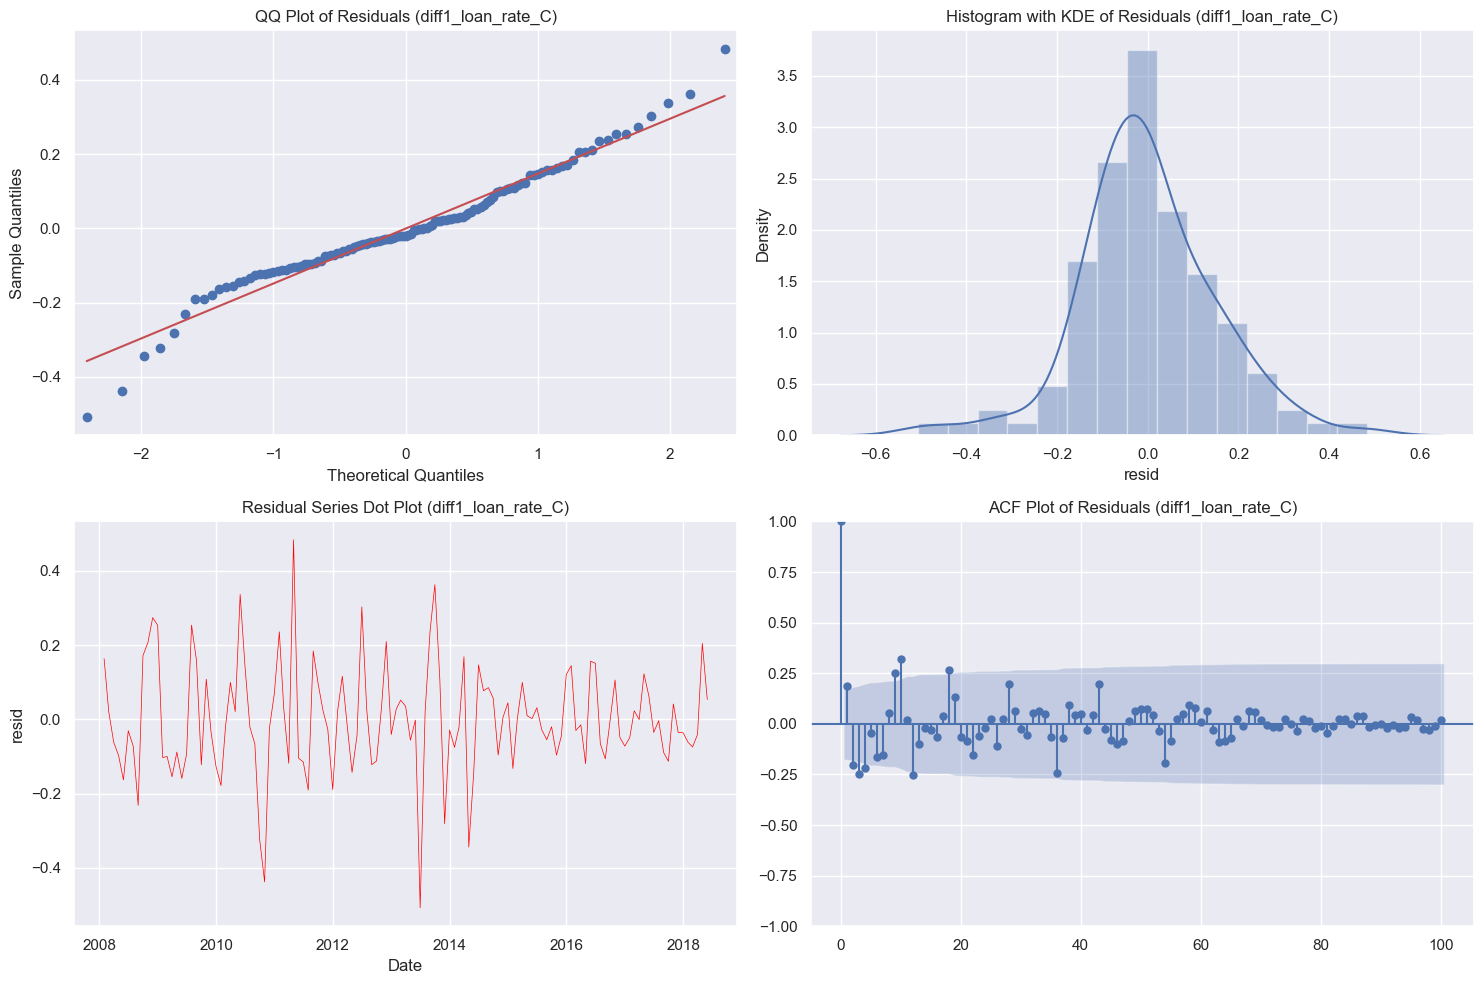

/Users/juanvalidmind/Library/Caches/pypoetry/virtualenvs/validmind-eEL8LtKG-py3.10/lib/python3.10/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


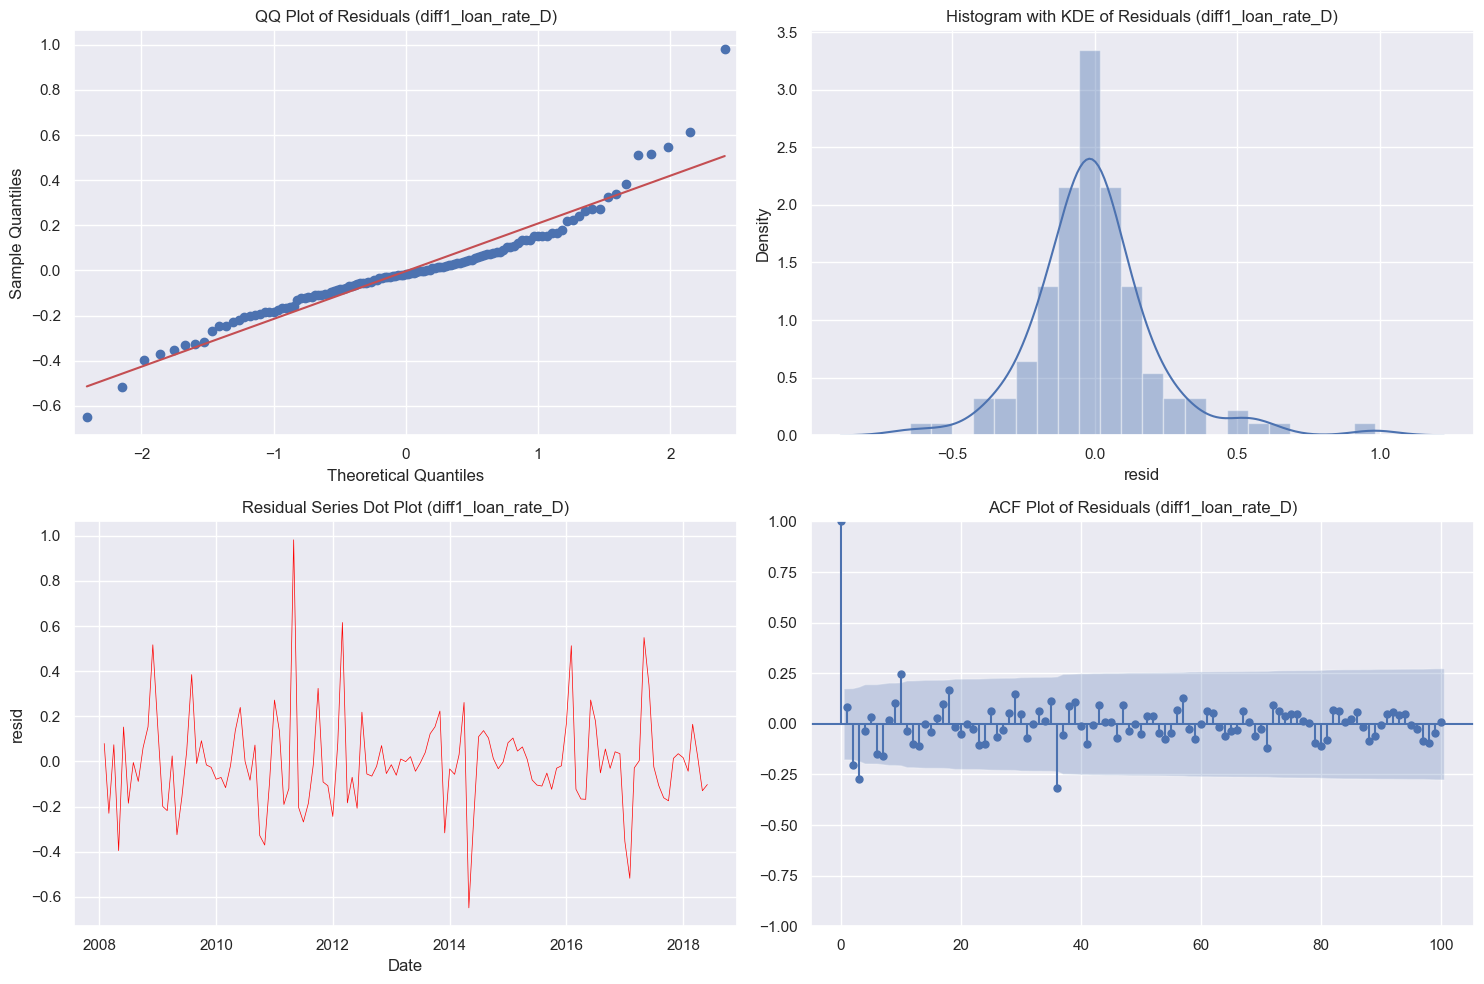

In [16]:
# Define a function to perform residual analysis
def residual_analysis(residuals, variable_name):
    residuals = residuals.dropna()  # drop NaN values
    fig, ax = plt.subplots(2, 2, figsize=(15, 10))
    ax = ax.flatten()
    
    # QQ plot
    qqplot(residuals, line='s', ax=ax[0])
    ax[0].set_title(f'QQ Plot of Residuals ({variable_name})')
    
    # Histogram with KDE
    sns.distplot(residuals, ax=ax[1])
    ax[1].set_title(f'Histogram with KDE of Residuals ({variable_name})')
    
    # Residual series dot plot
    sns.lineplot(data=residuals, linewidth=0.5, color='red', ax=ax[2])
    ax[2].set_title(f'Residual Series Dot Plot ({variable_name})')
    
    # ACF plot
    plot_acf(residuals, ax=ax[3], lags=100)
    ax[3].set_title(f'ACF Plot of Residuals ({variable_name})')
    
    plt.tight_layout()
    plt.show()


# Perform residual analysis for each variable
for variable_name in loan_rate_decompositions.keys():
    residual_analysis(loan_rate_decompositions[variable_name].resid, variable_name)

# Perform residual analysis for FEDFUNDS
residual_analysis(fed_funds_decomposition.resid, "FEDFUNDS")

# Perform residual analysis for each difference variable
for variable_name in diff_loan_rate_decompositions.keys():
    residual_analysis(diff_loan_rate_decompositions[variable_name].resid, variable_name)


Test if Residuals are Normaly Distributed.

In [17]:
# Remove Nan values before computing any test statistics.
for col in loan_rates.columns:
    loan_rate_decompositions[col].trend.dropna(inplace=True)
    loan_rate_decompositions[col].seasonal.dropna(inplace=True)
    loan_rate_decompositions[col].resid.dropna(inplace=True)

fed_funds_decomposition.trend.dropna(inplace=True)
fed_funds_decomposition.seasonal.dropna(inplace=True)
fed_funds_decomposition.resid.dropna(inplace=True)

for col in diff_loan_rates.columns:
    diff_loan_rate_decompositions[col].trend.dropna(inplace=True)
    diff_loan_rate_decompositions[col].seasonal.dropna(inplace=True)
    diff_loan_rate_decompositions[col].resid.dropna(inplace=True)

In [18]:
def compute_normality_statistics(data):
    ks_stat, ks_p = stats.kstest(data, 'norm')
    sw_stat, sw_p = stats.shapiro(data)
    lf_stat, lf_p = lilliefors(data)
    jb_stat, jb_p = stats.jarque_bera(data)

    return pd.DataFrame(
        {
            "Test": [
                "Kolmogorov-Smirnov",
                "Shapiro-Wilk",
                "Lilliefors",
                "Jarque-Bera",
            ],
            "Statistic": [ks_stat, sw_stat, lf_stat, jb_stat],
            "P-value": [ks_p, sw_p, lf_p, jb_p],
        }
    )



# Initialize an empty DataFrame to store the results
normality_statistics_results = pd.DataFrame()

# Compute normality statistics for each variable
for variable_name in loan_rate_decompositions.keys():
    data = loan_rate_decompositions[variable_name].resid
    normality_stats = compute_normality_statistics(data)
    normality_stats["Variable"] = variable_name
    normality_statistics_results = normality_statistics_results.append(normality_stats, ignore_index=True)

# Compute normality statistics for FEDFUNDS
data = fed_funds_decomposition.resid
normality_stats = compute_normality_statistics(data)
normality_stats["Variable"] = "FEDFUNDS"
normality_statistics_results = normality_statistics_results.append(normality_stats, ignore_index=True)

# Compute normality statistics for each difference variable
for variable_name in diff_loan_rate_decompositions.keys():
    data = diff_loan_rate_decompositions[variable_name].resid
    normality_stats = compute_normality_statistics(data)
    normality_stats["Variable"] = variable_name
    normality_statistics_results = normality_statistics_results.append(normality_stats, ignore_index=True)


In [31]:
def test_normality_statistics(normality_statistics_results, p_value_threshold=0.05):
    # Add a Pass/Fail column based on the p-value threshold
    normality_statistics_results['Pass/Fail'] = normality_statistics_results['P-value'].apply(lambda p: 'Pass' if p >= p_value_threshold else 'Fail')
    
    # Display the results as a table
    display(normality_statistics_results)

test_normality_statistics(normality_statistics_results, p_value_threshold=0.05)


Test   Statistic       P-value           Variable Pass/Fail
0   Kolmogorov-Smirnov    0.361205  4.090343e-15        loan_rate_A      Fail
1         Shapiro-Wilk    0.964680  2.367732e-03        loan_rate_A      Fail
2           Lilliefors    0.090317  2.188144e-02        loan_rate_A      Fail
3          Jarque-Bera   22.683894  1.186465e-05        loan_rate_A      Fail
4   Kolmogorov-Smirnov    0.316534  1.237558e-11        loan_rate_B      Fail
5         Shapiro-Wilk    0.950467  1.692832e-04        loan_rate_B      Fail
6           Lilliefors    0.112750  1.031154e-03        loan_rate_B      Fail
7          Jarque-Bera   24.607237  4.535305e-06        loan_rate_B      Fail
8   Kolmogorov-Smirnov    0.343031  1.229136e-13        loan_rate_C      Fail
9         Shapiro-Wilk    0.992633  7.564428e-01        loan_rate_C      Pass
10          Lilliefors    0.047168  7.618809e-01        loan_rate_C      Pass
11         Jarque-Bera    0.206857  9.017404e-01        loan_rate_C      Pass
12  Kolmogorov-Smirnov    0.312985  2.225322e-11        loan_rate_D      Fail
13        Shapiro-Wilk    0.989167  4.321428e-01        loan_rate_D      Pass
14          Lilliefors    0.045615  8.004312e-01        loan_rate_D      Pass
15         Jarque-Bera    1.373671  5.031658e-01        loan_rate_D      Pass
16  Kolmogorov-Smirnov    0.430685  1.396740e-21           FEDFUNDS      Fail
17        Shapiro-Wilk    0.759088  4.823187e-13           FEDFUNDS      Fail
18          Lilliefors    0.191270  1.000000e-03           FEDFUNDS      Fail
19         Jarque-Bera  255.448548  3.388852e-56           FEDFUNDS      Fail
20  Kolmogorov-Smirnov    0.361380  3.954988e-15  diff1_loan_rate_A      Fail
21        Shapiro-Wilk    0.943480  5.220129e-05  diff1_loan_rate_A      Fail
22          Lilliefors    0.106437  2.682603e-03  diff1_loan_rate_A      Fail
23         Jarque-Bera   32.392802  9.246818e-08  diff1_loan_rate_A      Fail
24  Kolmogorov-Smirnov    0.359857  5.300637e-15  diff1_loan_rate_B      Fail
25        Shapiro-Wilk    0.893433  5.663049e-08  diff1_loan_rate_B      Fail
26          Lilliefors    0.137282  1.000000e-03  diff1_loan_rate_B      Fail
27         Jarque-Bera  122.026511  3.178922e-27  diff1_loan_rate_B      Fail
28  Kolmogorov-Smirnov    0.376455  2.017554e-16  diff1_loan_rate_C      Fail
29        Shapiro-Wilk    0.970360  7.531957e-03  diff1_loan_rate_C      Fail
30          Lilliefors    0.086871  3.264423e-02  diff1_loan_rate_C      Fail
31         Jarque-Bera   12.705219  1.742195e-03  diff1_loan_rate_C      Fail
32  Kolmogorov-Smirnov    0.331651  9.369166e-13  diff1_loan_rate_D      Fail
33        Shapiro-Wilk    0.926674  4.010225e-06  diff1_loan_rate_D      Fail
34          Lilliefors    0.110326  1.665161e-03  diff1_loan_rate_D      Fail
35         Jarque-Bera  104.263860  2.287655e-23  diff1_loan_rate_D      Fail

Test if Residuals are Autocorrelated.

In [23]:
def compute_autocorrelation_statistics(data, lags=10):
    lb_results = acorr_ljungbox(data, lags=lags, return_df=True)
    lb_stat = lb_results['lb_stat'].iloc[-1]
    lb_p_value = lb_results['lb_pvalue'].iloc[-1]

    bp_results = acorr_ljungbox(data, lags=lags, boxpierce=True, return_df=True)
    bp_stat = bp_results['lb_stat'].iloc[-1]
    bp_p_value = bp_results['lb_pvalue'].iloc[-1]

    runs_stat, runs_p_value = runstest_1samp(data)
    
    return pd.DataFrame(
        {
            "Test": [                "Ljung-Box",                "Runs Test",                "Box-Pierce Test",            ],
            "Statistic": [                lb_stat,                runs_stat,                bp_stat,            ],
            "P-value": [                lb_p_value,                runs_p_value,                bp_p_value,            ],
        }
    )



In [24]:
# Initialize an empty DataFrame to store the results
autocorrelation_statistics_results = pd.DataFrame()

# Compute autocorrelation statistics for each variable
for variable_name in loan_rate_decompositions.keys():
    data = loan_rate_decompositions[variable_name].resid.dropna()
    autocorrelation_stats = compute_autocorrelation_statistics(data)
    autocorrelation_stats["Variable"] = variable_name
    autocorrelation_statistics_results = autocorrelation_statistics_results.append(autocorrelation_stats, ignore_index=True)

# Compute autocorrelation statistics for FEDFUNDS
data = fed_funds_decomposition.resid.dropna()
autocorrelation_stats = compute_autocorrelation_statistics(data)
autocorrelation_stats["Variable"] = "FEDFUNDS"
autocorrelation_statistics_results = autocorrelation_statistics_results.append(autocorrelation_stats, ignore_index=True)

# Compute autocorrelation statistics for each difference variable
for variable_name in diff_loan_rate_decompositions.keys():
    data = diff_loan_rate_decompositions[variable_name].resid.dropna()
    autocorrelation_stats = compute_autocorrelation_statistics(data)
    autocorrelation_stats["Variable"] = variable_name
    autocorrelation_statistics_results = autocorrelation_statistics_results.append(autocorrelation_stats, ignore_index=True)

autocorrelation_statistics_results = autocorrelation_statistics_results.reset_index(drop=True)




In [32]:
def test_autocorrelation_statistics(autocorrelation_statistics_results, p_value_threshold=0.05):
    
    autocorrelation_statistics_results['Threshold'] = p_value_threshold
    autocorrelation_statistics_results['P-value'] = pd.to_numeric(autocorrelation_statistics_results['P-value'], errors='coerce')
    
    autocorrelation_statistics_results['Pass/Fail'] = autocorrelation_statistics_results['P-value'].apply(
        lambda p: 'Pass' if p >= p_value_threshold else 'Fail'
    )
    display(autocorrelation_statistics_results)



    

In [34]:
test_autocorrelation_statistics(autocorrelation_statistics_results, p_value_threshold=0.01)

Test   Statistic       P-value           Variable  Threshold  \
0         Ljung-Box  116.663720  2.401553e-20        loan_rate_A       0.01   
1         Runs Test   -5.648902  1.614762e-08        loan_rate_A       0.01   
2   Box-Pierce Test  116.663720  2.401553e-20        loan_rate_A       0.01   
3         Ljung-Box  204.098406  2.253253e-38        loan_rate_B       0.01   
4         Runs Test   -6.375888  1.819052e-10        loan_rate_B       0.01   
5   Box-Pierce Test  204.098406  2.253253e-38        loan_rate_B       0.01   
6         Ljung-Box  125.601717  3.678593e-22        loan_rate_C       0.01   
7         Runs Test   -5.657398  1.536855e-08        loan_rate_C       0.01   
8   Box-Pierce Test  125.601717  3.678593e-22        loan_rate_C       0.01   
9         Ljung-Box   89.525260  6.651950e-15        loan_rate_D       0.01   
10        Runs Test   -6.008704  1.870119e-09        loan_rate_D       0.01   
11  Box-Pierce Test   89.525260  6.651950e-15        loan_rate_D       0.01   
12        Ljung-Box  169.890971  2.922023e-31           FEDFUNDS       0.01   
13        Runs Test   -6.518261  7.112729e-11           FEDFUNDS       0.01   
14  Box-Pierce Test  169.890971  2.922023e-31           FEDFUNDS       0.01   
15        Ljung-Box   31.658078  4.564856e-04  diff1_loan_rate_A       0.01   
16        Runs Test   -0.934551  3.500195e-01  diff1_loan_rate_A       0.01   
17  Box-Pierce Test   31.658078  4.564856e-04  diff1_loan_rate_A       0.01   
18        Ljung-Box   94.434755  7.038946e-16  diff1_loan_rate_B       0.01   
19        Runs Test   -0.627961  5.300294e-01  diff1_loan_rate_B       0.01   
20  Box-Pierce Test   94.434755  7.038946e-16  diff1_loan_rate_B       0.01   
21        Ljung-Box   54.151940  4.546097e-08  diff1_loan_rate_C       0.01   
22        Runs Test   -3.261335  1.108888e-03  diff1_loan_rate_C       0.01   
23  Box-Pierce Test   54.151940  4.546097e-08  diff1_loan_rate_C       0.01   
24        Ljung-Box   32.703162  3.054971e-04  diff1_loan_rate_D       0.01   
25        Runs Test   -1.632116  1.026551e-01  diff1_loan_rate_D       0.01   
26  Box-Pierce Test   32.703162  3.054971e-04  diff1_loan_rate_D       0.01   

   Pass/Fail  
0       Fail  
1       Fail  
2       Fail  
3       Fail  
4       Fail  
5       Fail  
6       Fail  
7       Fail  
8       Fail  
9       Fail  
10      Fail  
11      Fail  
12      Fail  
13      Fail  
14      Fail  
15      Fail  
16      Pass  
17      Fail  
18      Fail  
19      Pass  
20      Fail  
21      Fail  
22      Fail  
23      Fail  
24      Fail  
25      Pass  
26      Fail

**Step 3: Test for seasonality using the Augmented Dickey-Fuller (ADF) test**

**Step 4: Analyze the seasonality test results**

**Step 5: Interpret the results**

Based on the p-values from the ADF test, you can infer whether the time series are stationary or not. If the p-value is less than 0.05 (or your chosen significance level), you can reject the null hypothesis and conclude that the series is stationary. Otherwise, you fail to reject the null hypothesis and cannot conclude that the series is stationary.

**Step 6: Handle seasonality**

# 4.2. Methodology Selection and Development

## 4.2.4 Variable Analysis

  ## A. Feature Analysis

## A.1. Univariate Analysis

### **Visual Inspection**

## A.2 Multivariave Analysis

### **Visual Inspection**

## B. Variable Selection

## B.1 Selection Process

### **ARIMA Analysis**

**Step 1: Stationarity Analysis**

The first step in any time series analysis is to visualize the data and check for stationarity. Stationarity is important because most time series models, including ARIMA, assume that the underlying data is stationary.

In [ ]:
# Check stationarity for all columns
results = pd.DataFrame(columns=['Column', 'ADF Statistic', 'p-value', 'Stationary'])
for col in df.columns:
    # Perform ADF test
    result = adfuller(df[col])
    pval = result[1]
    stationary = 'Yes' if pval < 0.05 else 'No'
    results = results.append({'Column': col, 'ADF Statistic': result[0], 'p-value': pval, 'Stationary': stationary}, ignore_index=True)

# Display results in a table
sns.set(style='whitegrid')
table = sns.catplot(data=results, x='Column', y='ADF Statistic', hue='Stationary', kind='bar', height=5, aspect=2)
table.set_xticklabels(rotation=45)
table.ax.set_title('Stationarity Test Results')
table.ax.set_xlabel('Column')
table.ax.set_ylabel('ADF Statistic')




**Step 2: Identify the order of the AR model**

The order of the autoregressive (AR) model can be determined by looking at the partial autocorrelation function (PACF) plot. The PACF shows the correlation between a time series and its lagged values after accounting for the correlation at all shorter lags.

In [ ]:
def find_ar_order(column, max_lag):
    pacf_values, pacf_confidence_intervals = pacf(column, nlags=max_lag, alpha=0.05, method="ywmle")
    
    for lag, pacf_value, ci in zip(range(len(pacf_values)), pacf_values, pacf_confidence_intervals):
        if pacf_value <= ci[1]:
            return lag - 1

    return None

max_lag = 10  # Maximum lag to consider
ar_orders = {}

for col in df.columns:
    ar_order = find_ar_order(df[col], max_lag)
    ar_orders[col] = ar_order

# Create a DataFrame from the ar_orders dictionary
ar_orders_df = pd.DataFrame.from_dict(ar_orders, orient='index', columns=['AR_order'])
ar_orders_df.reset_index(inplace=True)
ar_orders_df.columns = ['Column', 'AR_order']

# Display the DataFrame
display(ar_orders_df)
